# 1. Introduction

The dataset in this capstone is an amalgamation of two individual datasets from the National Health and Nutrition Examination Survey (NHANES) from the 2015-2016 year. NHANES is a program of the National Center for Health Statistics, which is a subdivision of the Center for Disease Control and Prevention (CDC). NHANES data is collected every year and examines a nationally representative sample of approximately 5,000 people each time, who are located in 15 counties across the United States. The survey includes demographic, socioeconomic, and health-related questions, and the examination portion of the study includes medical, dental, and body measurements, as well as numerous lab tests. (For more information, see [NHANES](https://www.cdc.gov/nchs/nhanes/about_nhanes.htm).)

The dataset used here in this supervised learning capstone combines the NHANES 2015-16 "Demographic Variables and Sample Weights (DEMO_I)" dataset and the "Hospital Utilization and Access to Care (HUQ_I)" dataset. For more information about these datasets, the NHANES [DEMO_I](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm) and [HUQ_I](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/HUQ_I.htm) documentation details all questions asked, responses to them, and general information on how the data was collected and processed.

To summarize, the DEMO_I data comes from the NHANES demographics questionnaire, which was asked in respondents' homes, using the Computer-Assisted Personal Interview (CAPI) system, which allowed to respondents to select English or Spanish as their language of choice, or alternatively, to request an interpreter. All adults answered questions directly, while a proxy answered questions on behalf of those under 16 or who were not able to answer for themselves. The HUQ_I (hospital utilization and access to care) data was collected in exactly the same way as DEMO_I.

# 2. Research Question
To what extent can incidences of overnight hospitalization be predicted with NHANES demographic and hospital utilization features from the 2015-2016 year?

# 3. Data


### About the data
The DEMO_I dataset comes from an XPT file found [here](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT), on the NHANES 2015-2016 page. Likewise, the HUQ_I dataset comes from an XPT file found [here](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/HUQ_I.XPT). There are 9970 observations in both datasets, and their sequence numbers (row IDs) were identical, so they were easily concatenated. 
(Now add your screenshots here)

### Cleaning the data
The DEMO_I dataset originally had 47 columns. After cleaning, 29 remained. This is because columns containing more than 1000 nulls were removed, as this was deemed too large a percentage to reasonably impute data. After removing the columsn with more than 1000 null values, the columns with less than 1000 null values were dealt with on a case by case basis. Here, 3 columns were dropped because they were either copies of another, very similar column, or because the information in them was deemed irrelevant to the model (e.g., only 9 positive cases out of 9000 total observations). During this part of the cleaning process, 6 columns were imputed with the code '1000', so the missing data (which was recorded as nulls) could be used. 1000 was chosen, because it was sufficiently different from all other codes used in this research study, that it would not be mistaken for anything else.

The HUQ_I dataset originally had 10 columns. After cleaning, 8 columns remained, as 2 columns contained largely nulls and little else. Additionally, there were 3 columns contained a low enough amount of missing data (stored as null values) that it could be easily imputed with the code 1000, as mentioned previously.

When these two datasets were combined, the concatenated dataset was named demo_huq, and 2 more column that just had a small amount of missing data that were overlooked before were imputed with the code 1000 where needed. At this point, there were 37 columns, two of which were the 'seqn' columns that held the ID numbers for each row. There were also several more columns that were either copies of other columns or things that wouldn't be used in the model, such as a variable concerning the 'data release cycle' and another on 'interview/examination status' of the participants. After removing these, there were 26 columns left.


Then, all columns were re-coded to start with 0 rather than 1, as NHANES had made them, because it will be far easier for models to interpret data in binary format. After recoding, the age variable ('dmdhrage') was changed from categorical to continuous, both for ease of showing it with other variables in visualizations and also because separating the ages into distinct groups may make it easier to spot differences between age groups in the amount of overnight hospitalizations. The re-coded variables as well as the new categorical age variable (called 'dmdhrage_cat') were placed in a new dataframe called 'demo_huq_recode.' The dmdhrage_cat variable had a very small amount of null values present in it after being made categorical, so these were removed. Additionally, dmdhrage_cat was automatically made a 'category' type variable, but it needed to be a float like all the other variables, so the dataframe was copied into a new one called demo_huq_floatdf, and dmdhrage_cat was turned into a float64 type variable. 

At this point, in the final dataset, there were 9954 observations and a total of 27 columns (because dmdhrage_cat was added).  It was then time to prepare for building the models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statistics
!pip install xport
import xport
from scipy import stats
from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm

In [2]:
#I think pyspark is a precursor to installing xgboost
!pip install pyspark

In [3]:
# getting xgboost set up
!pip install xgboost 

In [4]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [5]:
with open('/Users/Heather/Downloads/DEMO_I.XPT', 'rb') as f:  #rb is mode to open xpt files, which are in unusual binary format
    demo = xport.to_dataframe(f)

In [6]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 47 columns):
SEQN        9971 non-null float64
SDDSRVYR    9971 non-null float64
RIDSTATR    9971 non-null float64
RIAGENDR    9971 non-null float64
RIDAGEYR    9971 non-null float64
RIDAGEMN    695 non-null float64
RIDRETH1    9971 non-null float64
RIDRETH3    9971 non-null float64
RIDEXMON    9544 non-null float64
RIDEXAGM    4060 non-null float64
DMQMILIZ    6149 non-null float64
DMQADFC     527 non-null float64
DMDBORN4    9971 non-null float64
DMDCITZN    9969 non-null float64
DMDYRSUS    2236 non-null float64
DMDEDUC3    2647 non-null float64
DMDEDUC2    5719 non-null float64
DMDMARTL    5719 non-null float64
RIDEXPRG    1288 non-null float64
SIALANG     9971 non-null float64
SIAPROXY    9970 non-null float64
SIAINTRP    9971 non-null float64
FIALANG     9642 non-null float64
FIAPROXY    9642 non-null float64
FIAINTRP    9642 non-null float64
MIALANG     6977 non-null float64
MIAPROXY   

In [7]:
demo.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,83732.0,9.0,2.0,1.0,62.0,NaN,3.0,3.0,1.0,NaN,...,5.0,1.0,3.0,134671.370419,135629.507405,1.0,125.0,10.0,10.0,4.39
1,83733.0,9.0,2.0,1.0,53.0,NaN,3.0,3.0,1.0,NaN,...,3.0,3.0,NaN,24328.560239,25282.425927,1.0,125.0,4.0,4.0,1.32
2,83734.0,9.0,2.0,1.0,78.0,NaN,3.0,3.0,2.0,NaN,...,3.0,1.0,3.0,12400.008522,12575.838818,1.0,131.0,5.0,5.0,1.51
3,83735.0,9.0,2.0,2.0,56.0,NaN,3.0,3.0,2.0,NaN,...,5.0,6.0,NaN,102717.995647,102078.634508,1.0,131.0,10.0,10.0,5.00
4,83736.0,9.0,2.0,2.0,42.0,NaN,4.0,4.0,2.0,NaN,...,4.0,3.0,NaN,17627.674984,18234.736219,2.0,126.0,7.0,7.0,1.23


In [8]:
null_count = demo.isnull().sum()   #checking how many nulls there are
print(null_count)

SEQN           0
SDDSRVYR       0
RIDSTATR       0
RIAGENDR       0
RIDAGEYR       0
RIDAGEMN    9276
RIDRETH1       0
RIDRETH3       0
RIDEXMON     427
RIDEXAGM    5911
DMQMILIZ    3822
DMQADFC     9444
DMDBORN4       0
DMDCITZN       2
DMDYRSUS    7735
DMDEDUC3    7324
DMDEDUC2    4252
DMDMARTL    4252
RIDEXPRG    8683
SIALANG        0
SIAPROXY       1
SIAINTRP       0
FIALANG      329
FIAPROXY     329
FIAINTRP     329
MIALANG     2994
MIAPROXY    2993
MIAINTRP    2993
AIALANGA    4009
DMDHHSIZ       0
DMDFMSIZ       0
DMDHHSZA       0
DMDHHSZB       0
DMDHHSZE       0
DMDHRGND       0
DMDHRAGE       0
DMDHRBR4     396
DMDHREDU     396
DMDHRMAR      62
DMDHSEDU    4745
WTINT2YR       0
WTMEC2YR       0
SDMVPSU        0
SDMVSTRA       0
INDHHIN2     345
INDFMIN2     329
INDFMPIR    1052
dtype: int64


In [9]:
null_over_1000 = null_count[null_count>=1000]
print(null_over_1000)     #I want to get rid of these columns; there are way too many nulls for them to be useful

RIDAGEMN    9276
RIDEXAGM    5911
DMQMILIZ    3822
DMQADFC     9444
DMDYRSUS    7735
DMDEDUC3    7324
DMDEDUC2    4252
DMDMARTL    4252
RIDEXPRG    8683
MIALANG     2994
MIAPROXY    2993
MIAINTRP    2993
AIALANGA    4009
DMDHSEDU    4745
INDFMPIR    1052
dtype: int64


In [10]:
null_over_1000 = null_over_1000.index       #indexing null_over_1000 so I can drop all these columns at once
print(null_over_1000)

Index(['RIDAGEMN', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC', 'DMDYRSUS', 'DMDEDUC3',
       'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG', 'MIALANG', 'MIAPROXY', 'MIAINTRP',
       'AIALANGA', 'DMDHSEDU', 'INDFMPIR'],
      dtype='object')


In [11]:
demo = demo.drop(columns=null_over_1000, axis=1)

In [12]:
demo.info()   #great, that worked; all columns with more than 1000 nulls have been dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 32 columns):
SEQN        9971 non-null float64
SDDSRVYR    9971 non-null float64
RIDSTATR    9971 non-null float64
RIAGENDR    9971 non-null float64
RIDAGEYR    9971 non-null float64
RIDRETH1    9971 non-null float64
RIDRETH3    9971 non-null float64
RIDEXMON    9544 non-null float64
DMDBORN4    9971 non-null float64
DMDCITZN    9969 non-null float64
SIALANG     9971 non-null float64
SIAPROXY    9970 non-null float64
SIAINTRP    9971 non-null float64
FIALANG     9642 non-null float64
FIAPROXY    9642 non-null float64
FIAINTRP    9642 non-null float64
DMDHHSIZ    9971 non-null float64
DMDFMSIZ    9971 non-null float64
DMDHHSZA    9971 non-null float64
DMDHHSZB    9971 non-null float64
DMDHHSZE    9971 non-null float64
DMDHRGND    9971 non-null float64
DMDHRAGE    9971 non-null float64
DMDHRBR4    9575 non-null float64
DMDHREDU    9575 non-null float64
DMDHRMAR    9909 non-null float64
WTINT2YR 

*screenshots from NHANES DEMO_I codebook*

In [13]:
demo.columns = demo.columns.str.lower()   #convert column names to lowercase for easier typing

In [14]:
#Now let's see how many nulls we still have to deal with:
demo.isnull().sum()

seqn          0
sddsrvyr      0
ridstatr      0
riagendr      0
ridageyr      0
ridreth1      0
ridreth3      0
ridexmon    427
dmdborn4      0
dmdcitzn      2
sialang       0
siaproxy      1
siaintrp      0
fialang     329
fiaproxy    329
fiaintrp    329
dmdhhsiz      0
dmdfmsiz      0
dmdhhsza      0
dmdhhszb      0
dmdhhsze      0
dmdhrgnd      0
dmdhrage      0
dmdhrbr4    396
dmdhredu    396
dmdhrmar     62
wtint2yr      0
wtmec2yr      0
sdmvpsu       0
sdmvstra      0
indhhin2    345
indfmin2    329
dtype: int64

Okay, here's what I'll do with the rest of the nulls (those columns that only have a few hundred or less):

ridexmon is unimportant to this analysis --> I'm going to drop the column

fialang (family's language) is something I want to keep --> I'll change the NaNs to code '1000' so they can become a 'real' part of the variable

fiaproxy (was a proxy respondent used for family interview) is unimportant here (only 9 used a proxy) --> drop column

fiainterp (was interpreter used) I want to keep --> change missing to code 1000

dmdhrbr4 is basically copy of dmdborn --> drop column

dmdhredu (education level) is important --> change missing to 1000

dmdhrmar (marital status) is important --> change missing to 1000

indhhin2 (annual household income) I'm keeping --> change missing to 1000

indfmin2 (annual family income) I'm also keeping --> change missing to 1000

In [15]:
missing_list = demo[['fialang', 'fiaintrp', 'dmdhredu', 'dmdhrmar', 'indhhin2', 'indfmin2']]

for column in missing_list:
  demo.loc[:, column] = demo.loc[:, column].fillna(1000)

In [16]:
demo.fialang.unique()  #great, now the coded value for the previously missing values (NaNs) is 1000 

array([   1.,    2., 1000.])

In [17]:
demo = demo.drop(columns=['fiaproxy', 'ridexmon', 'dmdhrbr4'])

In [18]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 29 columns):
seqn        9971 non-null float64
sddsrvyr    9971 non-null float64
ridstatr    9971 non-null float64
riagendr    9971 non-null float64
ridageyr    9971 non-null float64
ridreth1    9971 non-null float64
ridreth3    9971 non-null float64
dmdborn4    9971 non-null float64
dmdcitzn    9969 non-null float64
sialang     9971 non-null float64
siaproxy    9970 non-null float64
siaintrp    9971 non-null float64
fialang     9971 non-null float64
fiaintrp    9971 non-null float64
dmdhhsiz    9971 non-null float64
dmdfmsiz    9971 non-null float64
dmdhhsza    9971 non-null float64
dmdhhszb    9971 non-null float64
dmdhhsze    9971 non-null float64
dmdhrgnd    9971 non-null float64
dmdhrage    9971 non-null float64
dmdhredu    9971 non-null float64
dmdhrmar    9971 non-null float64
wtint2yr    9971 non-null float64
wtmec2yr    9971 non-null float64
sdmvpsu     9971 non-null float64
sdmvstra 

Great, now I'm ready to add in the hospital utilization & access to care dataset, clean it, and concatenate it.

In [19]:
with open('/Users/Heather/Downloads/HUQ_I.XPT', 'rb') as f:
    huq = xport.to_dataframe(f)

In [20]:
huq.info()    #it's great that it has 9971 entries, so it should be easy to attach to the demographics dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 10 columns):
SEQN      9971 non-null float64
HUQ010    9971 non-null float64
HUQ020    9575 non-null float64
HUQ030    9971 non-null float64
HUQ041    8631 non-null float64
HUQ051    9971 non-null float64
HUQ061    1421 non-null float64
HUQ071    9971 non-null float64
HUD080    869 non-null float64
HUQ090    8794 non-null float64
dtypes: float64(10)
memory usage: 779.1 KB


In [21]:
huq.columns = huq.columns.str.lower()   #making columns lowercase

In [22]:
huq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 10 columns):
seqn      9971 non-null float64
huq010    9971 non-null float64
huq020    9575 non-null float64
huq030    9971 non-null float64
huq041    8631 non-null float64
huq051    9971 non-null float64
huq061    1421 non-null float64
huq071    9971 non-null float64
hud080    869 non-null float64
huq090    8794 non-null float64
dtypes: float64(10)
memory usage: 779.1 KB


In [23]:
print(demo['seqn'].head())
print(huq['seqn'].head())    #making sure both datasets are lined up with corresponding IDs
print(demo['seqn'].tail())   #so we know the rows will still be for 1 observation only
print(huq['seqn'].tail())    

0    83732.0
1    83733.0
2    83734.0
3    83735.0
4    83736.0
Name: seqn, dtype: float64
0    83732.0
1    83733.0
2    83734.0
3    83735.0
4    83736.0
Name: seqn, dtype: float64
9966    93698.0
9967    93699.0
9968    93700.0
9969    93701.0
9970    93702.0
Name: seqn, dtype: float64
9966    93698.0
9967    93699.0
9968    93700.0
9969    93701.0
9970    93702.0
Name: seqn, dtype: float64


For the HUQ dataset, I'm definitely going to want to change the column names, because currently they give no information about what's in the columns. I'll do that first.

In [24]:
#rename all columns in huq
huq = huq.rename(columns={              
    "huq010": "gen_cond", 
    "huq020": "health_now", 
    "huq030": "routine_place", 
    "huq041": "type_place", 
    "huq051": "times_receive", 
    "huq061": "time_since",
    "huq071": "ovrnight_hosp",
    "hud080": "times_ovrnight",
    "huq090": "mental_health"})

In [25]:
huq.head()

,seqn,gen_cond,health_now,routine_place,type_place,times_receive,time_since,ovrnight_hosp,times_ovrnight,mental_health
0,83732.0,3.0,2.0,1.0,1.0,5.0,NaN,2.0,NaN,2.0
1,83733.0,2.0,3.0,1.0,6.0,0.0,6.0,2.0,NaN,2.0
2,83734.0,4.0,3.0,1.0,5.0,2.0,NaN,2.0,NaN,2.0
3,83735.0,2.0,3.0,1.0,2.0,4.0,NaN,2.0,NaN,1.0
4,83736.0,5.0,2.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0


In [26]:
huq.isnull().sum()    #now let's deal with huq nulls

seqn                 0
gen_cond             0
health_now         396
routine_place        0
type_place        1340
times_receive        0
time_since        8550
ovrnight_hosp        0
times_ovrnight    9102
mental_health     1177
dtype: int64

In [27]:
#remove time_since & times_ovrnight, since they have almost ALL nulls:
huq = huq.drop(columns=['time_since', 'times_ovrnight'])

Even though type_place & mental_health have a lot of nulls, I think these may be quite important, so I'm going to fill the nulls with code 1000 (just like in the demo dataset) so we can still use them.

The health_now column may or may not end up being important, but it has a relatively small amount of nulls, so I will fill them with code 1000 here too.

In [28]:
fill_list = huq[['type_place', 'mental_health', 'health_now']]

for column in fill_list:
  huq.loc[:, column] = huq.loc[:, column].fillna(1000)

In [29]:
huq.info()    #great!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 8 columns):
seqn             9971 non-null float64
gen_cond         9971 non-null float64
health_now       9971 non-null float64
routine_place    9971 non-null float64
type_place       9971 non-null float64
times_receive    9971 non-null float64
ovrnight_hosp    9971 non-null float64
mental_health    9971 non-null float64
dtypes: float64(8)
memory usage: 623.3 KB


In [30]:
#now it's time to concatenate demo & huq 
demo_huq = pd.concat([demo.reset_index(drop=True), huq.reset_index(drop=True)], axis=1)

In [31]:
demo_huq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 37 columns):
seqn             9971 non-null float64
sddsrvyr         9971 non-null float64
ridstatr         9971 non-null float64
riagendr         9971 non-null float64
ridageyr         9971 non-null float64
ridreth1         9971 non-null float64
ridreth3         9971 non-null float64
dmdborn4         9971 non-null float64
dmdcitzn         9969 non-null float64
sialang          9971 non-null float64
siaproxy         9970 non-null float64
siaintrp         9971 non-null float64
fialang          9971 non-null float64
fiaintrp         9971 non-null float64
dmdhhsiz         9971 non-null float64
dmdfmsiz         9971 non-null float64
dmdhhsza         9971 non-null float64
dmdhhszb         9971 non-null float64
dmdhhsze         9971 non-null float64
dmdhrgnd         9971 non-null float64
dmdhrage         9971 non-null float64
dmdhredu         9971 non-null float64
dmdhrmar         9971 non-null floa

In [32]:
#now I'm noticing dmdcitzn and siaproxy both have 1-2 missing values; I'm going to also fill with '1000':

fill_list2 = demo_huq[['dmdcitzn', 'siaproxy']]

for column in fill_list2:
  demo_huq.loc[:, column] = demo_huq.loc[:, column].fillna(1000)

In [33]:
demo_huq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 37 columns):
seqn             9971 non-null float64
sddsrvyr         9971 non-null float64
ridstatr         9971 non-null float64
riagendr         9971 non-null float64
ridageyr         9971 non-null float64
ridreth1         9971 non-null float64
ridreth3         9971 non-null float64
dmdborn4         9971 non-null float64
dmdcitzn         9971 non-null float64
sialang          9971 non-null float64
siaproxy         9971 non-null float64
siaintrp         9971 non-null float64
fialang          9971 non-null float64
fiaintrp         9971 non-null float64
dmdhhsiz         9971 non-null float64
dmdfmsiz         9971 non-null float64
dmdhhsza         9971 non-null float64
dmdhhszb         9971 non-null float64
dmdhhsze         9971 non-null float64
dmdhrgnd         9971 non-null float64
dmdhrage         9971 non-null float64
dmdhredu         9971 non-null float64
dmdhrmar         9971 non-null floa

In [34]:
target = demo_huq.ovrnight_hosp      #calling this target for now, just for visualizing

In [35]:
#getting rid of continuous/extraneous vars so they don't show up in the charts; I don't anticipate using these except dmdhrage
cat_features = demo_huq.drop(columns=[
              'seqn', 'seqn', 'dmdhrage', 'ridageyr', 'wtint2yr', 'wtmec2yr', 'sddsrvyr', 'ridstatr', 'sdmvpsu', 'sdmvstra'])

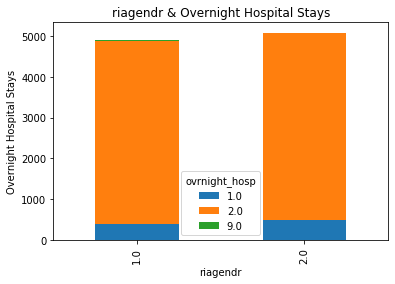

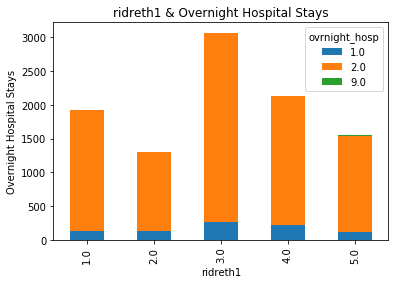

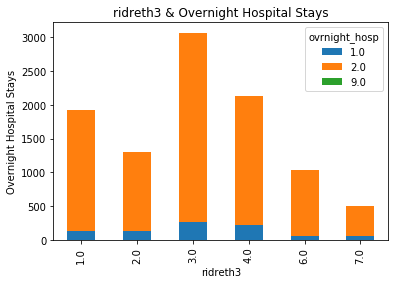

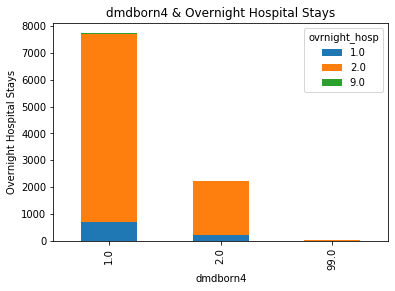

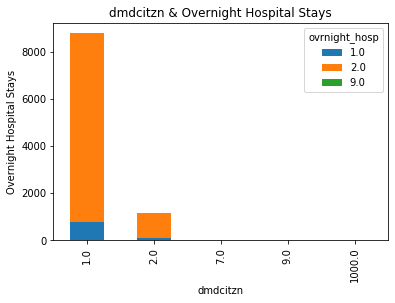

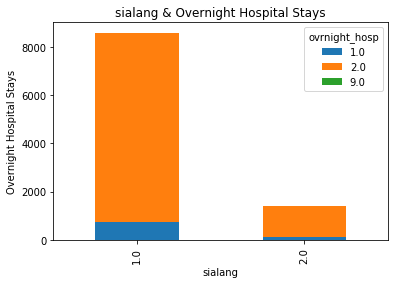

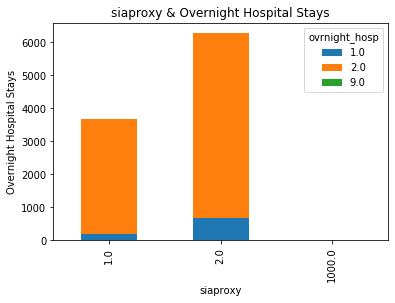

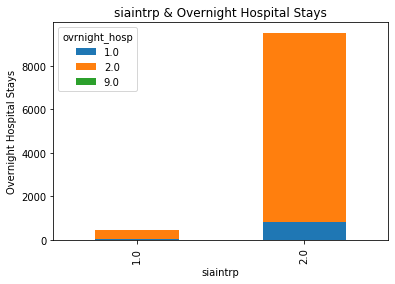

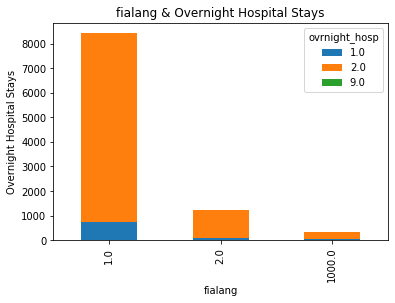

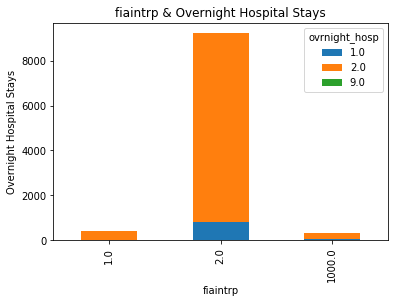

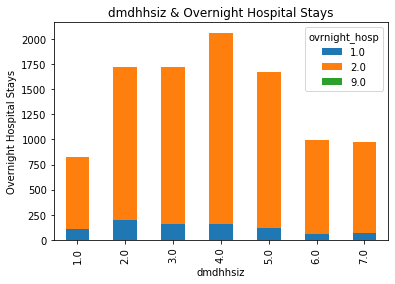

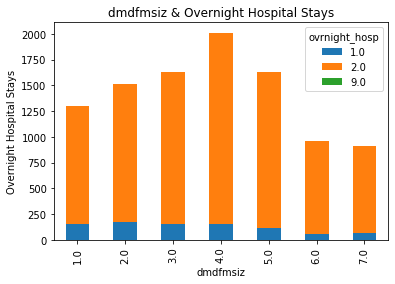

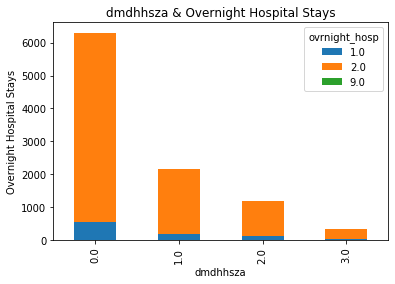

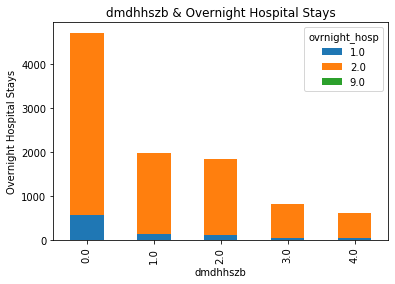

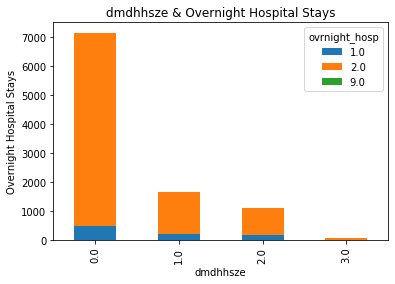

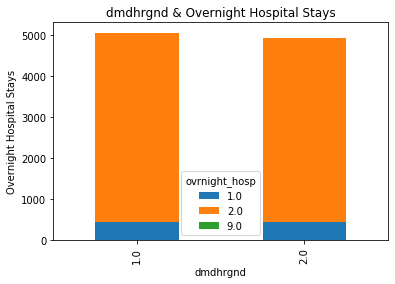

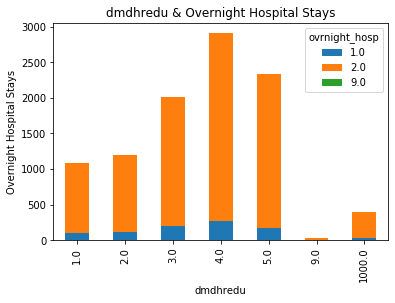

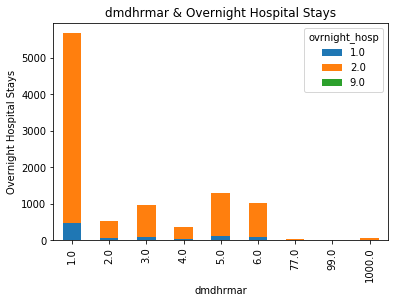

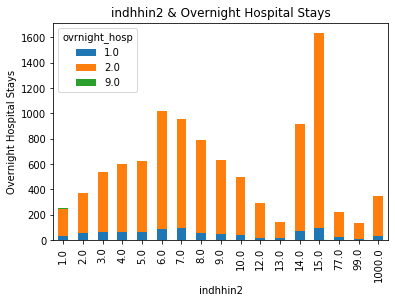

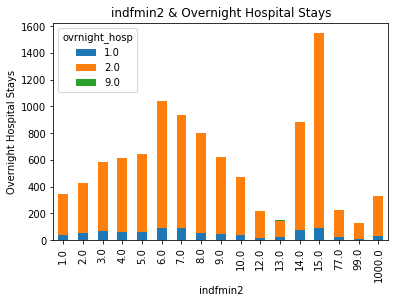

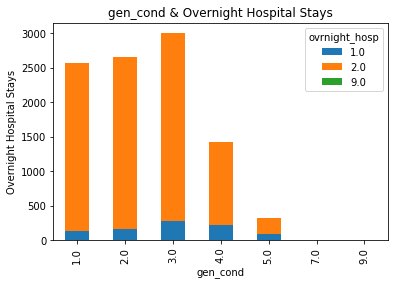

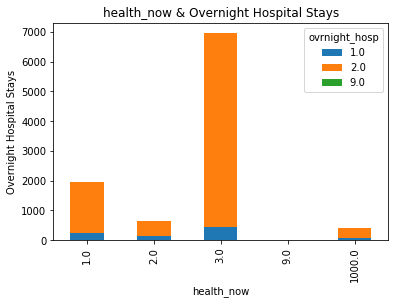

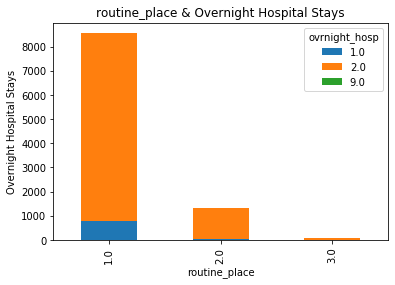

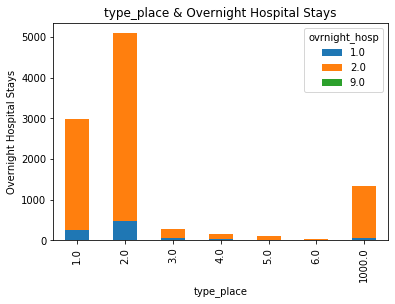

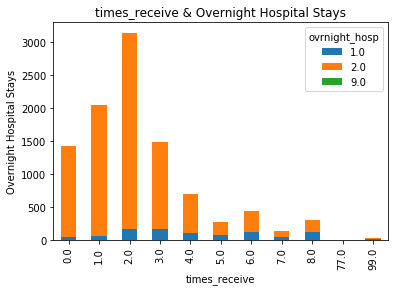

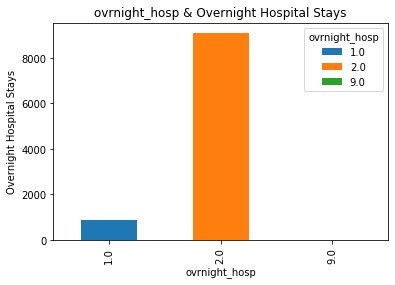

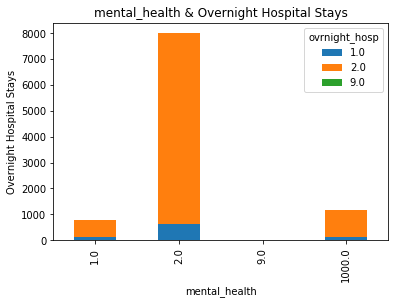

In [36]:
#plotting categorical features against y value of overnight hosp stays:

for column in cat_features:
  pd.crosstab(cat_features[column], target).plot(kind='bar', stacked=True)
  plt.title('{} & Overnight Hospital Stays'.format(column))
  plt.xlabel('{}'.format(column))
  plt.ylabel('Overnight Hospital Stays')
  plt.show()


So that was useful. First I'm going to recode many of these variables (into not so many brackets) and re-run the above barplots to visualize what happens with that change.

Then I want to pull out the variables from the barplots that are most salient to this analysis - just so we can see them better/bigger. Maybe I'll plot them a different way too.

In [37]:
#recoding those variables that have possibly too many buckets:
demo_huq_recode = demo_huq.copy()   #keeping all as floats in the recode simply for consistency

#citizenship:
demo_huq_recode.loc[demo_huq_recode['dmdcitzn'] == 1.0, 'dmdcitzn'] = 0.0   #US citizen
demo_huq_recode.loc[demo_huq_recode['dmdcitzn'] == 2.0, 'dmdcitzn'] = 1.0   #not US citizen
demo_huq_recode.loc[demo_huq_recode['dmdcitzn'] == 79.0, 'dmdcitzn'] = 2.0
demo_huq_recode.loc[demo_huq_recode['dmdcitzn'] == 1000.0, 'dmdcitzn'] = 2.0   #other

#household size:
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 1.0, 'dmdhhsiz'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 2.0, 'dmdhhsiz'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 3.0, 'dmdhhsiz'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 4.0, 'dmdhhsiz'] = 0.0   #1-4 people
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 5.0, 'dmdhhsiz'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 6.0, 'dmdhhsiz'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsiz'] == 7.0, 'dmdhhsiz'] = 1.0   #6+ people

#family size:
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 1.0, 'dmdfmsiz'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 2.0, 'dmdfmsiz'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 3.0, 'dmdfmsiz'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 4.0, 'dmdfmsiz'] = 0.0   #1-4 people
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 5.0, 'dmdfmsiz'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 6.0, 'dmdfmsiz'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdfmsiz'] == 7.0, 'dmdfmsiz'] = 1.0   #5+ people

#number of children in house under 5 y/o:
demo_huq_recode.loc[demo_huq_recode['dmdhhsza'] == 0.0, 'dmdhhsza'] = 0.0   #none
demo_huq_recode.loc[demo_huq_recode['dmdhhsza'] == 1.0, 'dmdhhsza'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsza'] == 2.0, 'dmdhhsza'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsza'] == 3.0, 'dmdhhsza'] = 1.0   #1 or more

#number of children in house 6-17 y/o:
demo_huq_recode.loc[demo_huq_recode['dmdhhszb'] == 0.0, 'dmdhhszb'] = 0.0   #none
demo_huq_recode.loc[demo_huq_recode['dmdhhszb'] == 1.0, 'dmdhhszb'] = 1.0   
demo_huq_recode.loc[demo_huq_recode['dmdhhszb'] == 2.0, 'dmdhhszb'] = 1.0   #1-2
demo_huq_recode.loc[demo_huq_recode['dmdhhszb'] == 3.0, 'dmdhhszb'] = 2.0   
demo_huq_recode.loc[demo_huq_recode['dmdhhszb'] == 4.0, 'dmdhhszb'] = 2.0   #3 or more

#number of adults in house 60+ y/o:
demo_huq_recode.loc[demo_huq_recode['dmdhhsze'] == 0.0, 'dmdhhsze'] = 0.0   #none
demo_huq_recode.loc[demo_huq_recode['dmdhhsze'] == 1.0, 'dmdhhsze'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsze'] == 2.0, 'dmdhhsze'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhhsze'] == 3.0, 'dmdhhsze'] = 1.0   #1 or more

#level of education attained:
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 1.0, 'dmdhredu'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 2.0, 'dmdhredu'] = 0.0   #these 2 are no HS diploma
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 3.0, 'dmdhredu'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 4.0, 'dmdhredu'] = 1.0   #HS diploma & partial college
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 5.0, 'dmdhredu'] = 2.0   #college grad or above
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 7.0, 'dmdhredu'] = 3.0
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 9.0, 'dmdhredu'] = 3.0   #other
demo_huq_recode.loc[demo_huq_recode['dmdhredu'] == 1000.0, 'dmdhredu'] = 3.0

#marital status:
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 1.0, 'dmdhrmar'] = 0.0
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 6.0, 'dmdhrmar'] = 0.0   #1&6 are together b/c it's married & living w/ partner
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 2.0, 'dmdhrmar'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 3.0, 'dmdhrmar'] = 1.0
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 4.0, 'dmdhrmar'] = 1.0   #these are once married but no longer together
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 5.0, 'dmdhrmar'] = 2.0   #never married
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 7.0, 'dmdhrmar'] = 3.0
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 99.0, 'dmdhrmar'] = 3.0
demo_huq_recode.loc[demo_huq_recode['dmdhrmar'] == 1000.0, 'dmdhrmar'] = 3.0   #other

#household income:
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 1.0, 'indhhin2'] = 0.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 2.0, 'indhhin2'] = 0.0   
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 3.0, 'indhhin2'] = 0.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 4.0, 'indhhin2'] = 0.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 13.0, 'indhhin2'] = 0.0  # $19,999 & under (13 was unknown amt under $20k)
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 5.0, 'indhhin2'] = 1.0   
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 6.0, 'indhhin2'] = 1.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 7.0, 'indhhin2'] = 1.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 8.0, 'indhhin2'] = 1.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 12.0, 'indhhin2'] = 1.0    # $20k to $54,999 (12 was unknown amt > $20k)
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 9.0, 'indhhin2'] = 2.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 10.0, 'indhhin2'] = 2.0    # $55k to $74,999
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 14.0, 'indhhin2'] = 3.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 15.0, 'indhhin2'] = 3.0    # $75k & over
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 77.0, 'indhhin2'] = 4.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 99.0, 'indhhin2'] = 4.0
demo_huq_recode.loc[demo_huq_recode['indhhin2'] == 1000.0, 'indhhin2'] = 4.0    #other

#family income:
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 1.0, 'indfmin2'] = 0.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 2.0, 'indfmin2'] = 0.0   
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 3.0, 'indfmin2'] = 0.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 4.0, 'indfmin2'] = 0.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 13.0, 'indfmin2'] = 0.0  # $19,999 & under (13 was unknown amt < $20k)
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 5.0, 'indfmin2'] = 1.0   
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 6.0, 'indfmin2'] = 1.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 7.0, 'indfmin2'] = 1.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 8.0, 'indfmin2'] = 1.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 12.0, 'indfmin2'] = 1.0    # $20k to $54,999 (12 was unknown amt > $20k)
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 9.0, 'indfmin2'] = 2.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 10.0, 'indfmin2'] = 2.0    # $55k to $74,999
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 14.0, 'indfmin2'] = 3.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 15.0, 'indfmin2'] = 3.0    # $75k & over
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 77.0, 'indfmin2'] = 4.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 99.0, 'indfmin2'] = 4.0
demo_huq_recode.loc[demo_huq_recode['indfmin2'] == 1000.0, 'indfmin2'] = 4.0    #other

#general health condition:
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 1.0, 'gen_cond'] = 0.0
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 2.0, 'gen_cond'] = 0.0
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 3.0, 'gen_cond'] = 0.0   #good to excellent
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 4.0, 'gen_cond'] = 1.0
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 5.0, 'gen_cond'] = 1.0   #fair or poor
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 7.0, 'gen_cond'] = 2.0
demo_huq_recode.loc[demo_huq_recode['gen_cond'] == 9.0, 'gen_cond'] = 2.0   #other

#times person received healthcare in last yr:
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 0.0, 'times_receive'] = 0.0
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 1.0, 'times_receive'] = 0.0   #0-1 time
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 2.0, 'times_receive'] = 1.0
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 3.0, 'times_receive'] = 1.0   #2-5 times
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 4.0, 'times_receive'] = 2.0
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 5.0, 'times_receive'] = 2.0   #6-9 times
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 6.0, 'times_receive'] = 3.0
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 7.0, 'times_receive'] = 3.0
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 8.0, 'times_receive'] = 3.0   #10 or more times
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 77.0, 'times_receive'] = 4.0
demo_huq_recode.loc[demo_huq_recode['times_receive'] == 99.0, 'times_receive'] = 4.0    #other

In [38]:
demo_huq_recode.head()

,seqn,sddsrvyr,ridstatr,riagendr,ridageyr,ridreth1,ridreth3,dmdborn4,dmdcitzn,sialang,...,indhhin2,indfmin2,seqn,gen_cond,health_now,routine_place,type_place,times_receive,ovrnight_hosp,mental_health
0,83732.0,9.0,2.0,1.0,62.0,3.0,3.0,1.0,0.0,1.0,...,2.0,2.0,83732.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0
1,83733.0,9.0,2.0,1.0,53.0,3.0,3.0,2.0,1.0,1.0,...,0.0,0.0,83733.0,0.0,3.0,1.0,6.0,0.0,2.0,2.0
2,83734.0,9.0,2.0,1.0,78.0,3.0,3.0,1.0,0.0,1.0,...,1.0,1.0,83734.0,1.0,3.0,1.0,5.0,1.0,2.0,2.0
3,83735.0,9.0,2.0,2.0,56.0,3.0,3.0,1.0,0.0,1.0,...,2.0,2.0,83735.0,0.0,3.0,1.0,2.0,2.0,2.0,1.0
4,83736.0,9.0,2.0,2.0,42.0,4.0,4.0,1.0,0.0,1.0,...,1.0,1.0,83736.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0


Next order of business (before visualizing the recoded data) is making sure all vars start with 0 (as opposed to beginning with 1), which will make the modeling stage a lot easier.

There are also a few columns I definitely don't want, so I'll drop them.

In [39]:
#getting rid of useless (to me) columns:
demo_huq_recode = demo_huq_recode.drop(columns=[
                'seqn', 'seqn', 'sddsrvyr', 'ridstatr', 'ridreth1', 'riagendr', 'ridageyr', 'wtint2yr', 'wtmec2yr', 'sdmvstra', 'sdmvpsu'], axis=1)

In [40]:
demo_huq_recode.info()    #still left with 26 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 26 columns):
ridreth3         9971 non-null float64
dmdborn4         9971 non-null float64
dmdcitzn         9971 non-null float64
sialang          9971 non-null float64
siaproxy         9971 non-null float64
siaintrp         9971 non-null float64
fialang          9971 non-null float64
fiaintrp         9971 non-null float64
dmdhhsiz         9971 non-null float64
dmdfmsiz         9971 non-null float64
dmdhhsza         9971 non-null float64
dmdhhszb         9971 non-null float64
dmdhhsze         9971 non-null float64
dmdhrgnd         9971 non-null float64
dmdhrage         9971 non-null float64
dmdhredu         9971 non-null float64
dmdhrmar         9971 non-null float64
indhhin2         9971 non-null float64
indfmin2         9971 non-null float64
gen_cond         9971 non-null float64
health_now       9971 non-null float64
routine_place    9971 non-null float64
type_place       9971 non-null floa

In [41]:
print(demo_huq_recode.ridreth3.unique())    #changing cols I haven't already recoded to 0, 1, etc.

[3. 4. 1. 2. 6. 7.]


In [42]:
demo_huq_recode.ridreth3 = demo_huq_recode.ridreth3 - 1

In [43]:
print(demo_huq_recode.ridreth3.unique())  #ridreth3 is fixed

[2. 3. 0. 1. 5. 6.]


In [44]:
print(demo_huq_recode.dmdborn4.unique()) 

[ 1.  2. 99.]


In [45]:
demo_huq_recode.dmdborn4 = demo_huq_recode.dmdborn4 - 1

In [46]:
print(demo_huq_recode.dmdborn4.unique())  #dmdborn4 is fixed

[ 0.  1. 98.]


In [47]:
print(demo_huq_recode.sialang.unique())

[1. 2.]


In [48]:
demo_huq_recode.sialang = demo_huq_recode.sialang - 1

In [49]:
print(demo_huq_recode.sialang.unique()) #sialang is fixed

[0. 1.]


In [50]:
print(demo_huq_recode.siaproxy.unique())

[   2.    1. 1000.]


In [51]:
#I don't want to change the 1000, so I'm going to recode rather than blanket subtract 1:
demo_huq_recode.loc[demo_huq_recode['siaproxy'] == 1.0, 'siaproxy'] = 0.0
demo_huq_recode.loc[demo_huq_recode['siaproxy'] == 2.0, 'siaproxy'] = 1.0   

print(demo_huq_recode.siaproxy.unique())

[   1.    0. 1000.]


In [52]:
print(demo_huq_recode.siaintrp.unique())

demo_huq_recode.siaintrp = demo_huq_recode.siaintrp - 1

print(demo_huq_recode.siaintrp.unique())  #siaintrp is fixed

[2. 1.]
[1. 0.]


In [53]:
print(demo_huq_recode.fialang.unique())   #again, don't want to change 1000, so recode

[   1.    2. 1000.]


In [54]:
demo_huq_recode.loc[demo_huq_recode['fialang'] == 1.0, 'fialang'] = 0.0
demo_huq_recode.loc[demo_huq_recode['fialang'] == 2.0, 'fialang'] = 1.0   

print(demo_huq_recode.fialang.unique())   #fialang is fixed

[   0.    1. 1000.]


In [55]:
print(demo_huq_recode.fiaintrp.unique())  #don't want to change 1000, so recode

[   2.    1. 1000.]


In [56]:
demo_huq_recode.loc[demo_huq_recode['fiaintrp'] == 1.0, 'fiaintrp'] = 0.0
demo_huq_recode.loc[demo_huq_recode['fiaintrp'] == 2.0, 'fiaintrp'] = 1.0   

print(demo_huq_recode.fiaintrp.unique())    #fiaintrp is fixed

[   1.    0. 1000.]


In [57]:
print(demo_huq_recode.dmdhrgnd.unique()) 

demo_huq_recode.dmdhrgnd = demo_huq_recode.dmdhrgnd - 1

print(demo_huq_recode.dmdhrgnd.unique())  #dmdhrgnd is fixed

[1. 2.]
[0. 1.]


In [58]:
demo_huq_recode.health_now.unique()   #don't wanna change 1000 or 9, so recode

array([   2.,    3.,    1., 1000.,    9.])

In [59]:
demo_huq_recode.loc[demo_huq_recode['health_now'] == 1.0, 'health_now'] = 0.0
demo_huq_recode.loc[demo_huq_recode['health_now'] == 2.0, 'health_now'] = 1.0   
demo_huq_recode.loc[demo_huq_recode['health_now'] == 3.0, 'health_now'] = 2.0

print(demo_huq_recode.health_now.unique())    #health_now is fixed

[   1.    2.    0. 1000.    9.]


In [60]:
print(demo_huq_recode.routine_place.unique())

demo_huq_recode.routine_place = demo_huq_recode.routine_place - 1

print(demo_huq_recode.routine_place.unique())  #routine_place is fixed

[1. 2. 3.]
[0. 1. 2.]


In [61]:
print(demo_huq_recode.type_place.unique())  #don't wanna change 1000, so recode

[   1.    6.    5.    2.    4. 1000.    3.]


In [62]:
demo_huq_recode.loc[demo_huq_recode['type_place'] == 1.0, 'type_place'] = 0.0
demo_huq_recode.loc[demo_huq_recode['type_place'] == 2.0, 'type_place'] = 1.0   
demo_huq_recode.loc[demo_huq_recode['type_place'] == 3.0, 'type_place'] = 2.0
demo_huq_recode.loc[demo_huq_recode['type_place'] == 4.0, 'type_place'] = 3.0
demo_huq_recode.loc[demo_huq_recode['type_place'] == 5.0, 'type_place'] = 4.0   
demo_huq_recode.loc[demo_huq_recode['type_place'] == 6.0, 'type_place'] = 5.0

print(demo_huq_recode.type_place.unique())    #type_place is fixed

[   0.    5.    4.    1.    3. 1000.    2.]


In [63]:
print(demo_huq_recode.ovrnight_hosp.unique())   #don't wanna change 9, so recode

[2. 1. 9.]


In [64]:
demo_huq_recode.loc[demo_huq_recode['ovrnight_hosp'] == 1.0, 'ovrnight_hosp'] = 0.0
demo_huq_recode.loc[demo_huq_recode['ovrnight_hosp'] == 2.0, 'ovrnight_hosp'] = 1.0

print(demo_huq_recode.ovrnight_hosp.unique())   #ovrnight_hosp is fixed

[1. 0. 9.]


In [65]:
print(demo_huq_recode.mental_health.unique())   #again, don't want to change 1000 or 9, so recode

[   2.    1. 1000.    9.]


In [66]:
demo_huq_recode.loc[demo_huq_recode['mental_health'] == 1.0, 'mental_health'] = 0.0
demo_huq_recode.loc[demo_huq_recode['mental_health'] == 2.0, 'mental_health'] = 1.0

print(demo_huq_recode.mental_health.unique())   #mental_health is fixed

[   1.    0. 1000.    9.]


Everything is now recoded/gotten rid of that needed to be. I'm ready to re-visualize and see if the smaller code buckets make anything clearer than before.

In [67]:
cat_features = demo_huq_recode.drop(columns=['dmdhrage'])   #dropping age for this viz since it's continuous

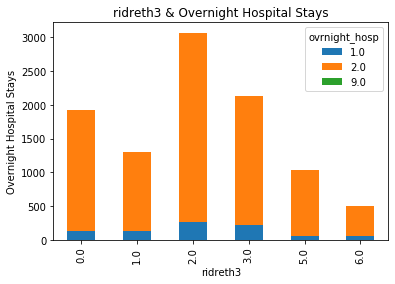

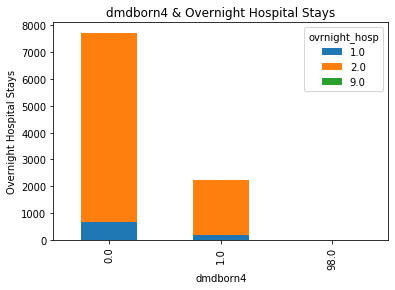

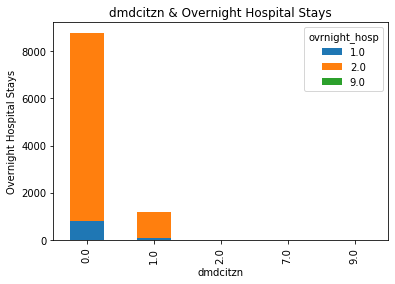

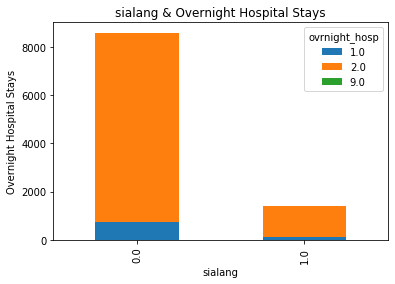

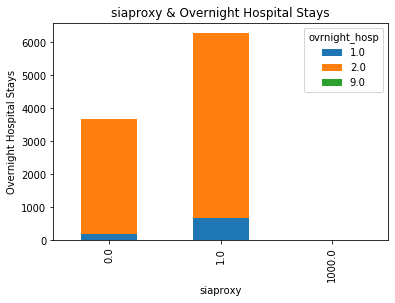

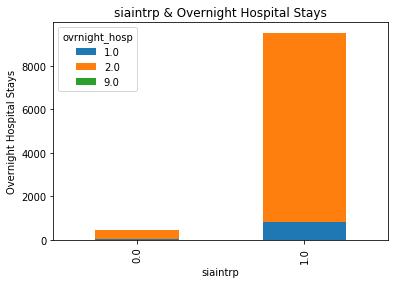

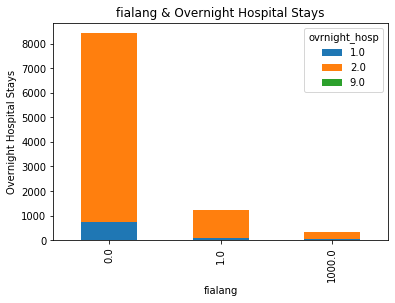

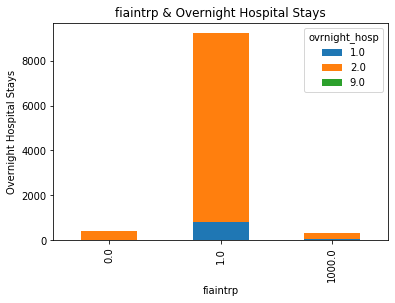

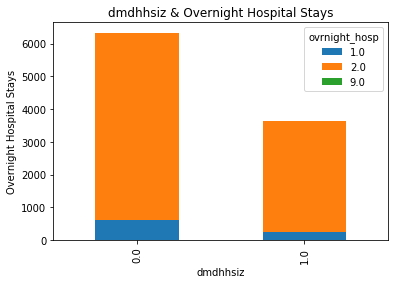

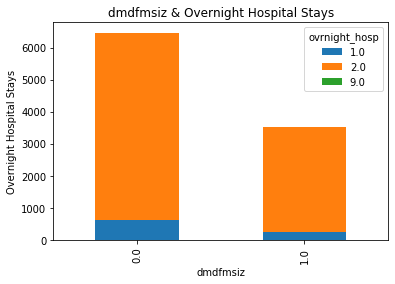

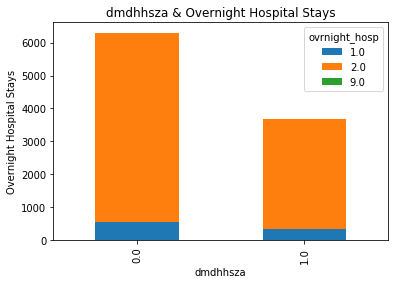

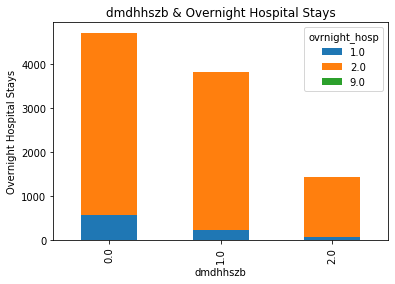

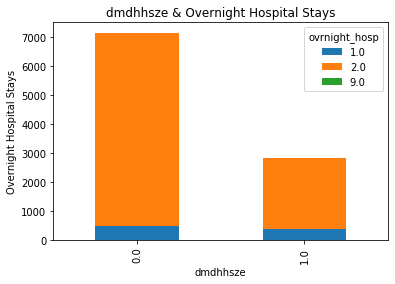

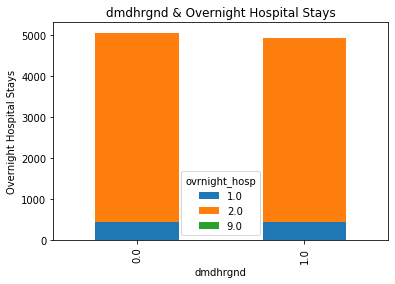

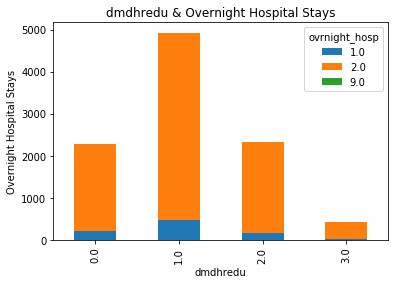

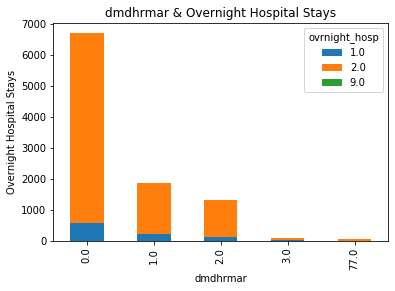

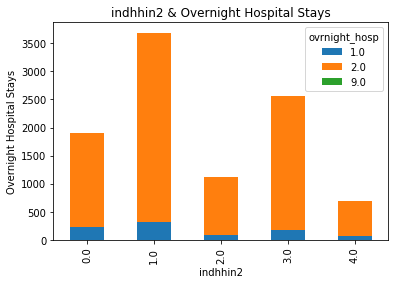

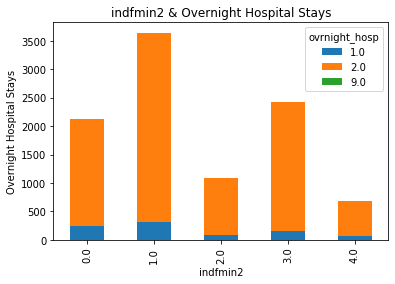

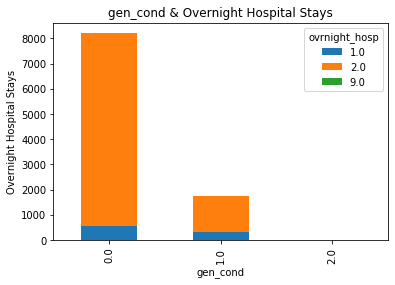

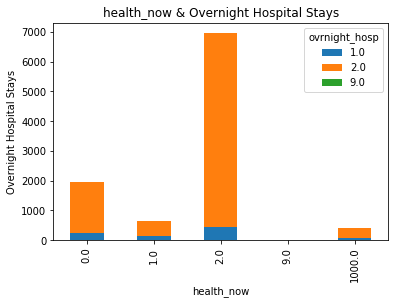

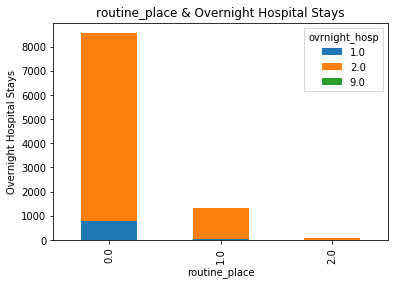

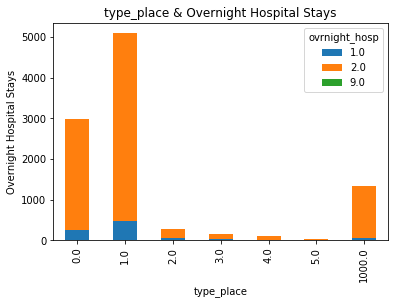

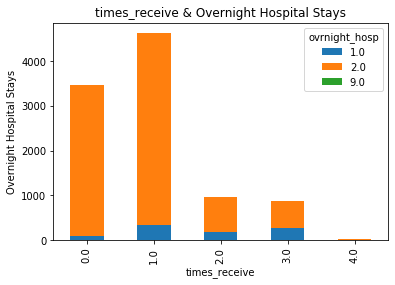

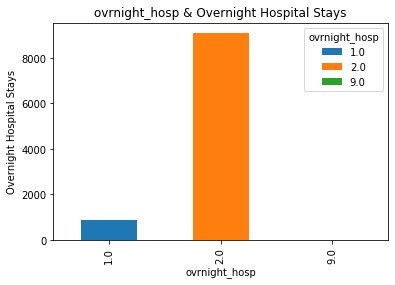

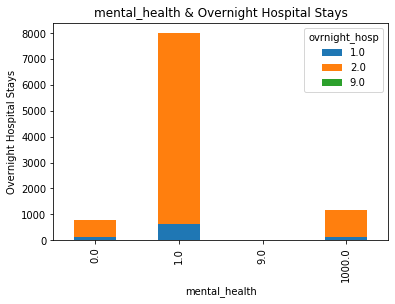

In [68]:
#plotting categorical features against y value of overnight hosp stays:

for column in cat_features:
  pd.crosstab(cat_features[column], target).plot(kind='bar', stacked=True)
  plt.title('{} & Overnight Hospital Stays'.format(column))
  plt.xlabel('{}'.format(column))
  plt.ylabel('Overnight Hospital Stays')
  plt.show()


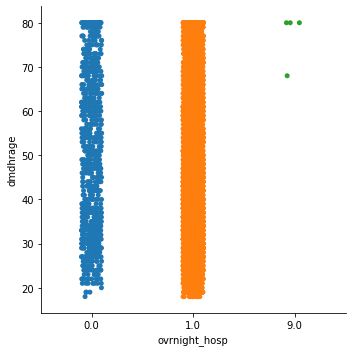

In [69]:
sns.catplot(x="ovrnight_hosp", y="dmdhrage", data=demo_huq_recode)
# plt.title('Relationship between Overnight Hospital Stays & Respondent Age')
# plt.xlabel('Overnight Hospital Stays')
# plt.ylabel('Age')
plt.show()      #this is not super helpful but that's ok

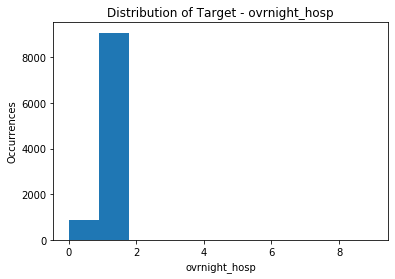

In [169]:
plt.hist(demo_huq_recode['ovrnight_hosp'])
plt.title('Distribution of Target - Overnight Hospital Stays in the Last Year')
plt.xlabel('ovrnight_hosp')
plt.ylabel('Occurrences')
plt.show()

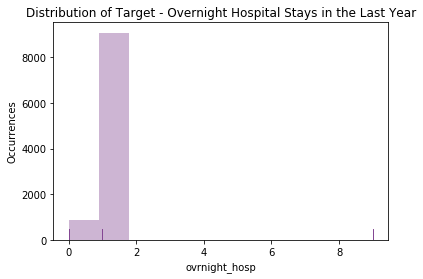

In [196]:
sns.set_palette('PRGn') #prettier
dist_fig = sns.distplot(demo_huq_recode['ovrnight_hosp'], kde=False, rug=True, bins=10)
plt.title('Distribution of Target - Overnight Hospital Stays in the Last Year')
plt.xlabel('ovrnight_hosp')
plt.ylabel('Occurrences')
plt.show()

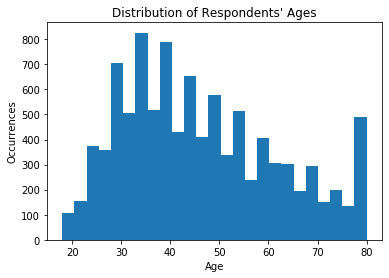

In [70]:
#Maybe a histogram of age would be helpful:
plt.hist(demo_huq_recode['dmdhrage'], bins=25)
plt.title("Distribution of Respondents' Ages")
plt.xlabel('Age')
plt.ylabel('Occurrences')
plt.show()

In [71]:
print(demo_huq_recode.dmdhrage.unique())
print(demo_huq_recode.dmdhrage.max())   #finding the oldest age represented in the dataset
print(demo_huq_recode.dmdhrage.min())

[62. 53. 79. 56. 42. 34. 68. 35. 48. 47. 31. 55. 45. 46. 54. 38. 64. 50.
 73. 67. 40. 57. 80. 43. 24. 21. 32. 28. 39. 49. 52. 22. 41. 69. 60. 70.
 66. 44. 27. 30. 37. 29. 26. 33. 36. 20. 23. 61. 76. 51. 71. 63. 77. 74.
 59. 19. 65. 75. 78. 72. 25. 58. 18.]
80.0
18.0


Alright, I'm thinking it may be more useful to put 'age' in buckets and make it categorical after all, esp. considering all the other variables in this dataset are categorical. I may be able to visualize it better that way as well.

In [72]:
#Here goes, making age categorical:
demo_huq_recode['dmdhrage_cat'] = pd.cut(demo_huq_recode.dmdhrage, bins=[18,30,40,50,60,70,80],labels=[0.0,1.0,2.0,3.0,4.0,5.0])

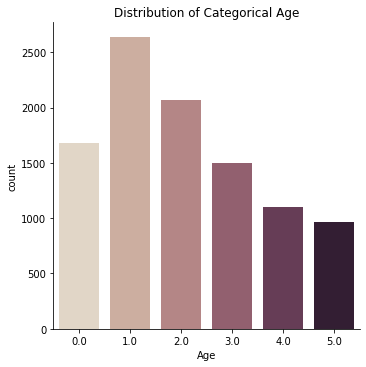

In [73]:
#visualizing new categorical age with catplot:
sns.catplot(x="dmdhrage_cat", kind="count", palette="ch:.25", data=demo_huq_recode)
plt.title('Distribution of Categorical Age')
plt.xlabel('Age')
plt.show()

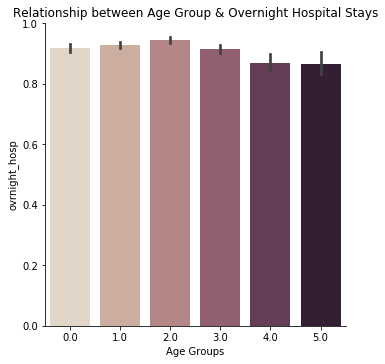

In [74]:
#Now let's plot these new age groups against overnight hospital stays:
sns.catplot(x="dmdhrage_cat", y="ovrnight_hosp", kind="bar", palette="ch:.25", data=demo_huq_recode)
plt.title('Relationship between Age Group & Overnight Hospital Stays')
plt.xlabel('Age Groups')
plt.show()

Interesting, the above plot is actually showing that the age group with the largest amount of people having spend a night in a hospital during the past year is 2.0, that is, ages 41-50.

<Figure size 1440x288 with 0 Axes>

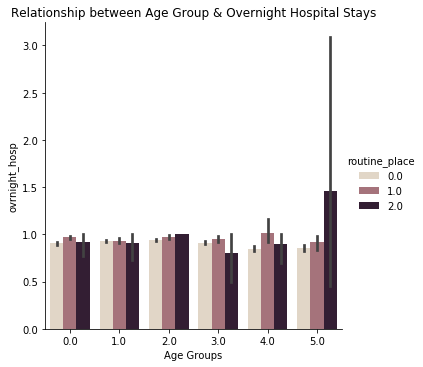

In [75]:
plt.figure(figsize=(20,4))
sns.catplot(x="dmdhrage_cat", y="ovrnight_hosp", hue="routine_place", kind="bar", palette="ch:.25", data=demo_huq_recode)
plt.title('Relationship between Age Group & Overnight Hospital Stays')
plt.xlabel('Age Groups')
plt.show()

I think the recoding and barplots were helpful, but since they are just dealing with counts, they can't really tell us which features will be most useful in a model. So, to get that information more empirically, I'm going to run correlations between all the variables and my proposed target (ovrnight_hosp).

In [76]:
cat_features = demo_huq_recode.drop(columns=['dmdhrage', 'ovrnight_hosp'], axis=1)

In [77]:
cat_features.columns  #making sure the new categorical age var is included in this

Index(['ridreth3', 'dmdborn4', 'dmdcitzn', 'sialang', 'siaproxy', 'siaintrp',
       'fialang', 'fiaintrp', 'dmdhhsiz', 'dmdfmsiz', 'dmdhhsza', 'dmdhhszb',
       'dmdhhsze', 'dmdhrgnd', 'dmdhredu', 'dmdhrmar', 'indhhin2', 'indfmin2',
       'gen_cond', 'health_now', 'routine_place', 'type_place',
       'times_receive', 'mental_health', 'dmdhrage_cat'],
      dtype='object')

In [78]:
demo_huq_recode.dmdhrage_cat.unique()   #apparently there are NaNs in the categorical age variable? let's look into this

[4.0, 3.0, 5.0, 2.0, 1.0, 0.0, NaN]
Categories (6, float64): [0.0 < 1.0 < 2.0 < 3.0 < 4.0 < 5.0]

In [79]:
demo_huq_recode.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 27 columns):
ridreth3         9971 non-null float64
dmdborn4         9971 non-null float64
dmdcitzn         9971 non-null float64
sialang          9971 non-null float64
siaproxy         9971 non-null float64
siaintrp         9971 non-null float64
fialang          9971 non-null float64
fiaintrp         9971 non-null float64
dmdhhsiz         9971 non-null float64
dmdfmsiz         9971 non-null float64
dmdhhsza         9971 non-null float64
dmdhhszb         9971 non-null float64
dmdhhsze         9971 non-null float64
dmdhrgnd         9971 non-null float64
dmdhrage         9971 non-null float64
dmdhredu         9971 non-null float64
dmdhrmar         9971 non-null float64
indhhin2         9971 non-null float64
indfmin2         9971 non-null float64
gen_cond         9971 non-null float64
health_now       9971 non-null float64
routine_place    9971 non-null float64
type_place       9971 non-null floa

There's only a very few nulls in the cat age variable, so we'll drop them. 

Also, 'dmdhrage' is registered as a category, but I want it to be a float like all the other variables here.

In [80]:
demo_huq_recode = demo_huq_recode.dropna()

demo_huq_recode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9970
Data columns (total 27 columns):
ridreth3         9954 non-null float64
dmdborn4         9954 non-null float64
dmdcitzn         9954 non-null float64
sialang          9954 non-null float64
siaproxy         9954 non-null float64
siaintrp         9954 non-null float64
fialang          9954 non-null float64
fiaintrp         9954 non-null float64
dmdhhsiz         9954 non-null float64
dmdfmsiz         9954 non-null float64
dmdhhsza         9954 non-null float64
dmdhhszb         9954 non-null float64
dmdhhsze         9954 non-null float64
dmdhrgnd         9954 non-null float64
dmdhrage         9954 non-null float64
dmdhredu         9954 non-null float64
dmdhrmar         9954 non-null float64
indhhin2         9954 non-null float64
indfmin2         9954 non-null float64
gen_cond         9954 non-null float64
health_now       9954 non-null float64
routine_place    9954 non-null float64
type_place       9954 non-null floa

In [81]:
demo_huq_floatdf = demo_huq_recode.copy()   #copying df just in case
demo_huq_floatdf.dmdhrage_cat = demo_huq_floatdf.astype({'dmdhrage_cat': 'float64'})   #casting cat age variable to float64

In [82]:
demo_huq_floatdf.info()   #double-checking everything is float64 now

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9970
Data columns (total 27 columns):
ridreth3         9954 non-null float64
dmdborn4         9954 non-null float64
dmdcitzn         9954 non-null float64
sialang          9954 non-null float64
siaproxy         9954 non-null float64
siaintrp         9954 non-null float64
fialang          9954 non-null float64
fiaintrp         9954 non-null float64
dmdhhsiz         9954 non-null float64
dmdfmsiz         9954 non-null float64
dmdhhsza         9954 non-null float64
dmdhhszb         9954 non-null float64
dmdhhsze         9954 non-null float64
dmdhrgnd         9954 non-null float64
dmdhrage         9954 non-null float64
dmdhredu         9954 non-null float64
dmdhrmar         9954 non-null float64
indhhin2         9954 non-null float64
indfmin2         9954 non-null float64
gen_cond         9954 non-null float64
health_now       9954 non-null float64
routine_place    9954 non-null float64
type_place       9954 non-null floa

# Methods

Here is a brief breakdown of the methods that will be used in model creation, optimization, and evaluation.

### Model creation
1. Separate the target from the categorical features (not going to use the continuous age variable).

2. Run Spearman correlations between all of these features and the target. As the variables here are all categorical (including the target), Spearman will be used, since it is the non-parametric version of correlation tests (whereas Pearson's R is for normally distributed variables).

3. Set a threshold for correlations (e.g., +/- .1) and plan to use all features at or above said threshold.

4. Check these chosen features for multicollinearity (using both a correlation matrix and heatmap). If any are highly multicollinearity, remove one from each multicollinear pair.

5. Based on the specifications of this data (i.e., it is not normally distributed, all categorical, requires a classification task, and is a modest size), three different types of models will be trained - a logistic regression, a random forest, and a gradient boosting model (GBM). Each model will be evaluated in terms of its accuracy score and area under the ROC curve (auc score). The best performing model of these three will be chosen as the final model.

### Model optimization
1. The logistic regression will be tried  in three forms, to try to find the best performing solver and type of regularization (if any). I'll use lbfgs (which is known to work well on fairly small datasets) with L2 regularization, saga (so I can try out L1 regularization), and lbfgs with no penalty. When I find which solver and type of regularization seems to work best for this data, I'll then iterate through several different values for max_iter to see if there is an optimal max_iter. For all of these logistic regression models, I'll use 8-fold cross-validation, and I'll use accuracy and auc scores as my scoring metrics in determining performance.

2. After the best logistic regression model from those I will have trained, I will run a feature importance analysis by retrieving the coefficients for each variable in the model, determining which are highest, and interpreting how each variable affects the target.

3. The random forest will first be run as a simple model with just the number of n_estimators specified, in order to get baseline scores for predictive power. Then, I will work on optimizing the random forest by manually running through numerous iterations with different n_estimators to find the optimal amount(s) of n_estimators for the model. Again, I'll be using 8-fold cross-validation, accuracy score, and auc score as evaluation metrics for all random forests. Once the best n_estimators is found, I'll run through numerous iterations with different max_depths, while keeping the n_estimators hyperparameter constant at what was found to be the optimal number. Once I have the best combination of n_estimators and max_depth, I will run a grid search to determine the best settings for other important hyperparameters (i.e., n_jobs, max_features, min_samples_leaf), leaving n_estimators and max_depth constant at the values I've determined to be optimal. In the event that the grid search ends up performing less well than my simpler iterations of random forests, I will simply go with the best random forest model I've achieved pre-grid search.

4. Then, a feature importance analysis will be run on the chosen random forest model, and levels of feature importance will be plotted as a bar graph.

5. The GBM will first be run as a simple model, only specifying the number of n_estimators to get a baseline (just as I began with the RF). Then, to be more efficient, I will use a randomized search to find the optimal set of hyperparameters from the following: learning_rate, n_estimators, max_depth, and max_features. Once the randomized search comes up with the best combination of hyperparameters, I will run a GBM with these exact hyperparameters, using 8-fold cross-validation and obtaining the accuracy and auc scores as evaluation metrics. 

6. I'll then run a feature importance analysis on the GBM, making sure it falls generally within the same range as the RF's feature importance. If it doesn't, something might have gone wrong.  

### Model evaluation
1. Supposing the feature importance analysis turns out find as expected, I can then compare the GBM's performance to the RF and the logistic regression. At this point, I will be able to choose the best model out of these three types and use it as my final model.

2. For whichever model I've ultimately chosen, I'll perform a statistical logistic regression on it, to figure out if I can make this model even better by potentially removing some features that may not be statistically significant. First, I'll run the statistical logistic regression with just a constant to determine the baseline; then, I'll run it with all features above a certain importance threshold included and see which are statistically significant to the model. If any are not, I'll remove them one at a time, to see how that removal affects the model. I will use the metrics of the entire model (AIC, BIC, p-value, log-likelihood, etc.) to determine whether the non-statistically significant feature should remain in the model or not. That is to say, if a feature is not statistically significant but still impacts the model positively overall, I will keep it in the model. 

3. Then, once I've found the best combination of features to keep in the final model (and potentially optimized it even more),  the statistical logistic regression coefficients will allow me to interpret the model better and determine what the odds are of a given outcome in the target, based on features' values. 

In [83]:
target = demo_huq_floatdf['ovrnight_hosp']
target.shape

(9954,)

In [84]:
cat_features = demo_huq_floatdf.drop(columns=['dmdhrage', 'ovrnight_hosp'], axis=1)  #resetting cat_features now that nulls gone
cat_features.shape

(9954, 25)

In [85]:
#getting correlations with ovrnight_hosp:
for column in cat_features:     
  corr = stats.spearmanr(cat_features[column], target)    #using spearman because target is non-normal
  print('The correlation between {} and ovrnight_hosp is: {}'.format(column, corr))

The correlation between ridreth3 and ovrnight_hosp is: SpearmanrResult(correlation=-0.01002300479165614, pvalue=0.31736274718606905)
The correlation between dmdborn4 and ovrnight_hosp is: SpearmanrResult(correlation=0.0007563950043003124, pvalue=0.9398520139680782)
The correlation between dmdcitzn and ovrnight_hosp is: SpearmanrResult(correlation=0.021640940768964615, pvalue=0.03084298362072008)
The correlation between sialang and ovrnight_hosp is: SpearmanrResult(correlation=0.0035273185077434395, pvalue=0.7249308604751212)
The correlation between siaproxy and ovrnight_hosp is: SpearmanrResult(correlation=-0.08955801418358636, pvalue=3.4894140429955787e-19)
The correlation between siaintrp and ovrnight_hosp is: SpearmanrResult(correlation=-0.012905476275242106, pvalue=0.19793126607153105)
The correlation between fialang and ovrnight_hosp is: SpearmanrResult(correlation=0.006575600393225094, pvalue=0.5118430348330404)
The correlation between fiaintrp and ovrnight_hosp is: SpearmanrResu

Hmm, there's no very high correlations, but that doesn't necessarily mean we can't build a good model out of these features.

I'm still interested in seeing if I can build a classifier to predict whether someone has stayed overnight in a hospital during the last year using this data.

I'm going to move ahead with ovrnight_hosp as the target and use the 19 features that are most correlated with it (that is, any that have a correlation of +/- .01 or higher with the target):

times_receive: -.241

gen_cond: -.150

dmdhhsze: -.108

dmdhhszb: .101

siaproxy: -.090

health_now: .071

routine_place: .055

dmdfmsiz: .054

dmdhhsiz: .052

indhhin2: .050

indfmin2: .047

dmdhredu: .026

mental_health: .026

dmdcitzn: .022

fiaintrp: -.018

dmdhrmar: -.014

siaintrp: -.013

ridreth3: -.010

dmdhrage_cat: -.010

Based on what happens with these, I might add more features or create new ones that could possibly predict better.

I'm going to start with logistic regression as my classifier.

First, however, I'll need to check whether any of these 5 features listed above are multicollinear.

In [86]:
X = demo_huq_floatdf[[
  'times_receive', 
  'gen_cond', 
  'dmdhhsze', 
  'dmdhhszb', 
  'siaproxy', 
  'health_now', 
  'routine_place', 
  'dmdfmsiz', 
  'dmdhhsiz',
  'indhhin2',
  'indfmin2',
  'dmdhredu',
  'mental_health',
  'dmdcitzn',
  'fiaintrp',
  'dmdhrmar',
  'siaintrp',
  'ridreth3',
  'dmdhrage_cat']]
y = demo_huq_floatdf['ovrnight_hosp']      #setting up features and target

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9970
Data columns (total 19 columns):
times_receive    9954 non-null float64
gen_cond         9954 non-null float64
dmdhhsze         9954 non-null float64
dmdhhszb         9954 non-null float64
siaproxy         9954 non-null float64
health_now       9954 non-null float64
routine_place    9954 non-null float64
dmdfmsiz         9954 non-null float64
dmdhhsiz         9954 non-null float64
indhhin2         9954 non-null float64
indfmin2         9954 non-null float64
dmdhredu         9954 non-null float64
mental_health    9954 non-null float64
dmdcitzn         9954 non-null float64
fiaintrp         9954 non-null float64
dmdhrmar         9954 non-null float64
siaintrp         9954 non-null float64
ridreth3         9954 non-null float64
dmdhrage_cat     9954 non-null float64
dtypes: float64(19)
memory usage: 1.5 MB


In [88]:
X.corr()    #checking for multicollinearity

,times_receive,gen_cond,dmdhhsze,dmdhhszb,siaproxy,health_now,routine_place,dmdfmsiz,dmdhhsiz,indhhin2,indfmin2,dmdhredu,mental_health,dmdcitzn,fiaintrp,dmdhrmar,siaintrp,ridreth3,dmdhrage_cat
times_receive,1.000000,0.184745,0.159929,-0.156390,-0.008558,0.080916,-0.207816,-0.106576,-0.107924,-0.036801,-0.032080,0.015700,0.111633,-0.098456,-0.006282,-0.002034,0.010468,-0.009245,-0.009245
gen_cond,0.184745,1.000000,0.177657,-0.101691,0.007122,-0.088307,0.014300,-0.059002,-0.055021,-0.149656,-0.146763,-0.159474,-0.143874,0.080235,0.011753,-0.003156,-0.053488,-0.113585,-0.113585
dmdhhsze,0.159929,0.177657,1.000000,-0.278827,0.008582,-0.092350,-0.038006,-0.122284,-0.126502,-0.060942,-0.048011,-0.025791,-0.164240,-0.032433,0.028624,-0.004032,-0.076923,0.006475,0.006475
dmdhhszb,-0.156390,-0.101691,-0.278827,1.000000,-0.012997,-0.055661,-0.036837,0.618548,0.620755,0.011012,0.033303,-0.120821,-0.065351,0.022750,-0.015397,-0.015143,-0.033339,-0.091273,-0.091273
siaproxy,-0.008558,0.007122,0.008582,-0.012997,1.000000,-0.014917,0.005049,-0.020686,-0.020616,-0.005328,-0.013771,-0.012943,-0.026669,0.004465,-0.000519,-0.001351,0.000960,-0.012380,-0.012380
health_now,0.080916,-0.088307,-0.092350,-0.055661,-0.014917,1.000000,-0.057195,0.033180,0.030653,-0.018903,-0.012415,-0.003862,0.555863,-0.057825,-0.005997,-0.010582,0.007818,-0.030867,-0.030867
routine_place,-0.207816,0.014300,-0.038006,-0.036837,0.005049,-0.057195,1.000000,-0.016560,-0.003565,-0.025188,-0.038181,-0.012506,-0.095056,0.115352,0.033494,-0.003471,0.001960,-0.010243,-0.010243
dmdfmsiz,-0.106576,-0.059002,-0.122284,0.618548,-0.020686,0.033180,-0.016560,1.000000,0.972416,0.024177,0.051959,-0.127760,0.081495,0.039377,0.007340,-0.041240,-0.065023,-0.113492,-0.113492
dmdhhsiz,-0.107924,-0.055021,-0.126502,0.620755,-0.020616,0.030653,-0.003565,0.972416,1.000000,0.023531,0.036735,-0.127969,0.078169,0.050824,0.003508,-0.029726,-0.064645,-0.114132,-0.114132
indhhin2,-0.036801,-0.149656,-0.060942,0.011012,-0.005328,-0.018903,-0.025188,0.024177,0.023531,1.000000,0.960951,0.346453,-0.017901,-0.023996,0.344067,-0.047363,0.040096,0.095900,0.095900


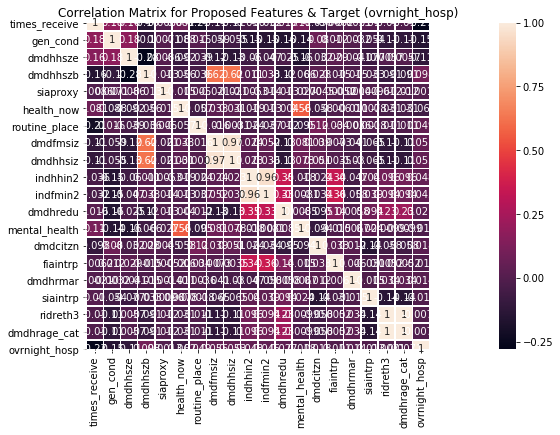

In [146]:
#I'm also going to make a heatmap to illustrate correlations between these features and y
corrmat_features = demo_huq_floatdf[[
  'times_receive', 
  'gen_cond', 
  'dmdhhsze', 
  'dmdhhszb', 
  'siaproxy', 
  'health_now', 
  'routine_place', 
  'dmdfmsiz', 
  'dmdhhsiz',
  'indhhin2',
  'indfmin2',
  'dmdhredu',
  'mental_health',
  'dmdcitzn',
  'fiaintrp',
  'dmdhrmar',
  'siaintrp',
  'ridreth3',
  'dmdhrage_cat', 
  'ovrnight_hosp']]  #including y w/ X to view corrs 

corrmat = corrmat_features.corr()
 
#making the heatmap       
plt.figure(figsize=(25,6))
sns.heatmap(corrmat, square=True, annot=True, linewidths=.6)
plt.title("Correlation Matrix for Proposed Features & Target (ovrnight_hosp)")
plt.show()

Okay, so it makes sense that the two measures of income (indhhin2 & indfmin2 are highly multicollinear, since they're basically measuring the same thing. Same with family/household size (dmdhhsiz & dmdfmsiz). Since this could be an issue, I'm going to remove family income and family size and just focus on household size and household income, for consistency.

In [90]:
X = demo_huq_floatdf[[                #removing family size and income from features; now I have 17 total
  'times_receive', 
  'gen_cond', 
  'dmdhhsze', 
  'dmdhhszb', 
  'siaproxy', 
  'health_now', 
  'routine_place',  
  'dmdhhsiz',
  'indhhin2',
  'dmdhredu',
  'mental_health',
  'dmdcitzn',
  'fiaintrp',
  'dmdhrmar',
  'siaintrp',
  'ridreth3',
  'dmdhrage_cat']]
y = demo_huq_floatdf['ovrnight_hosp']      #y is the same

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)  #splitting test & training sets

In [92]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=5000)   #multiclass logistic regression (ovr) w/ cross validation
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv = 8)

print('Accuracy scores for the 8 folds (training): ', lr_cv_scores)
print('Mean cross validation score (training): {:.3f}'.format(np.mean(lr_cv_scores)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


Accuracy scores for the 8 folds (training):  [0.91273821 0.9107322  0.91173521 0.91256281 0.91155779 0.90945674
 0.91348089 0.91146881]
Mean cross validation score (training): 0.912


In [93]:
lr_cv_scoresTest = cross_val_score(lr, X_test, y_test, cv = 8)

print('Accuracy score for the 8 folds (test): ', lr_cv_scoresTest)
print('Mean cross validation score (test): {:.3f}'.format(np.mean(lr_cv_scoresTest)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


Accuracy score for the 8 folds (test):  [0.916      0.91164659 0.91967871 0.90361446 0.92369478 0.90763052
 0.91566265 0.89878543]
Mean cross validation score (test): 0.912


In [97]:
lr.fit(X_train, y_train)
probs = lr.predict_proba(X_test)[:, :]

# lr_auc = roc_auc_score(y_test, probs)
# print('Area under the ROC curve: {:.3f}'.format(lr_auc))

Right, that's actually not too bad (.911 mean cv score for test set, but .781 auc score). However, I was worried about the least populated class being an issue - there are apparently only 3 people in the test set who didn't know whether they stayed in the hospital or not. I'm guessing this imbalance could be affecting the predictive power.

As there are only 4 of these people total, I don't think it will terribly mess with the data's integrity to remove them. So, that's what I'm going to do, and then I'll rerun the logistic regression and see if accuracy improves.

In [98]:
demo_huq_floatdf.ovrnight_hosp.value_counts()

1.0    9082
0.0     868
9.0       4
Name: ovrnight_hosp, dtype: int64

In [99]:
demo_huq_floatdf = demo_huq_floatdf[demo_huq_floatdf["ovrnight_hosp"] < 9.0]   #removing rows with class 9.0 from dataset

In [100]:
demo_huq_floatdf.info()    #checking that they are gone; and they are

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9970
Data columns (total 27 columns):
ridreth3         9950 non-null float64
dmdborn4         9950 non-null float64
dmdcitzn         9950 non-null float64
sialang          9950 non-null float64
siaproxy         9950 non-null float64
siaintrp         9950 non-null float64
fialang          9950 non-null float64
fiaintrp         9950 non-null float64
dmdhhsiz         9950 non-null float64
dmdfmsiz         9950 non-null float64
dmdhhsza         9950 non-null float64
dmdhhszb         9950 non-null float64
dmdhhsze         9950 non-null float64
dmdhrgnd         9950 non-null float64
dmdhrage         9950 non-null float64
dmdhredu         9950 non-null float64
dmdhrmar         9950 non-null float64
indhhin2         9950 non-null float64
indfmin2         9950 non-null float64
gen_cond         9950 non-null float64
health_now       9950 non-null float64
routine_place    9950 non-null float64
type_place       9950 non-null floa

Now that the respondents who didn't know their hospital stay status are removed, I'll re-run the logistic regression. It no longer needs to be a multi-class classifier, so I'll remove the ovr parameter as well. I'm just using the default penalty of l2 regularization.

In [101]:
X = demo_huq_floatdf[[                #re-setting X and y now that it's no longer a multiclass problem
  'times_receive', 
  'gen_cond', 
  'dmdhhsze', 
  'dmdhhszb', 
  'siaproxy', 
  'health_now', 
  'routine_place',  
  'dmdhhsiz',
  'indhhin2',
  'dmdhredu',
  'mental_health',
  'dmdcitzn',
  'fiaintrp',
  'dmdhrmar',
  'siaintrp',
  'ridreth3',
  'dmdhrage_cat']]
y = demo_huq_floatdf['ovrnight_hosp']      #y is the same

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)  #splitting test & training sets

In [103]:
lr = LogisticRegression(solver='lbfgs', max_iter=5000)   #binary logistic regression w/ cross validation
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv = 8)

print('Accuracy scores for the 8 folds (training): ', lr_cv_scores)    #getting scores for training set
print('Mean cross validation score (training): {:.3f}'.format(np.mean(lr_cv_scores)))

Accuracy scores for the 8 folds (training):  [0.90963855 0.91155779 0.91155779 0.91155779 0.91055276 0.90753769
 0.91155779 0.90945674]
Mean cross validation score (training): 0.910


In [104]:
lr_cv_scoresTest = cross_val_score(lr, X_test, y_test, cv = 8)

print('Accuracy score for the 8 folds (test): ', lr_cv_scoresTest)    #scores for test set
print('Mean cross validation score (test): {:.3f}'.format(np.mean(lr_cv_scoresTest)))

Accuracy score for the 8 folds (test):  [0.912      0.916      0.916      0.91532258 0.91935484 0.91532258
 0.91935484 0.91532258]
Mean cross validation score (test): 0.916


In [105]:
lr.fit(X_train, y_train)
probs = lr.predict_proba(X_test)[:, 1]

lr_auc = roc_auc_score(y_test, probs)
print('Area under the ROC curve: {:.3f}'.format(lr_auc))

Area under the ROC curve: 0.756


Removing the imbalanced class and using binary logistic regression seemed to help a little bit with the accuracy here (.911 mean accuracy), but not with the AUC score (now .755). 

Next (still using lbfgs solver & L2 regularization) I'm going to work with adjusting the max_iter parameter to hopefully find the optimal number of iterations.

In [106]:
#find optimal number for max_iter on test set:
for i in range(2000,8200,200):      #beginning at 2000 because earlier I tried 1000 and it failed to converge
  lr = LogisticRegression(solver='lbfgs', max_iter=i)
  print('Number of iterations: {}'.format(i))
  lr_cv_scores = cross_val_score(lr, X_test, y_test, cv=8)
  print('Accuracy scores for the 8 folds (test): ', lr_cv_scores) 
  print('Mean cross validation score (test): {:.3f}'.format(np.mean(lr_cv_scores)))
  lr.fit(X_train, y_train)
  probs = lr.predict_proba(X_test)[:, 1]
  lr_auc = roc_auc_score(y_test, probs)
  print('Area under the ROC curve: {:.3f}'.format(lr_auc))

Number of iterations: 2000
Accuracy scores for the 8 folds (test):  [0.912      0.916      0.916      0.91532258 0.91935484 0.91532258
 0.91935484 0.91532258]
Mean cross validation score (test): 0.916
Area under the ROC curve: 0.756
Number of iterations: 2200
Accuracy scores for the 8 folds (test):  [0.912      0.916      0.916      0.91532258 0.91935484 0.91532258
 0.91935484 0.91532258]
Mean cross validation score (test): 0.916
Area under the ROC curve: 0.756
Number of iterations: 2400
Accuracy scores for the 8 folds (test):  [0.912      0.916      0.916      0.91532258 0.91935484 0.91532258
 0.91935484 0.91532258]
Mean cross validation score (test): 0.916
Area under the ROC curve: 0.756
Number of iterations: 2600
Accuracy scores for the 8 folds (test):  [0.912      0.916      0.916      0.91532258 0.91935484 0.91532258
 0.91935484 0.91532258]
Mean cross validation score (test): 0.916
Area under the ROC curve: 0.756
Number of iterations: 2800
Accuracy scores for the 8 folds (test):  

Okay, well now I can be totally sure that max_iter isn't a factor here - the mean cv score and auc score remained the same throughout all the above iterations. However, I'm not totally done with logistic regression yet. It may be that a different solver and/or different regularization method could help.

Although I believe lbfgs probably is the best solver in this case - since this dataset is somewhat small, and lbfgs saves memory anyway - I'm going to try a couple other solvers anyway. First, because I'm interested in trying L1 regularization and elastic net regularization, I'm going to try using the saga solver, which can use both of these regularization types. After trying saga with each of these regularizations, I think it may then be time to move on to a different type of model. I'm not going to use the lib-linear solver, since it seems to work best with more large-scale problems & higher dimensionality.

In [147]:
#features and target remain the same for now, as do the X and y train_test_split
lr_saga_l1 = LogisticRegression(solver='saga', penalty='l1', max_iter=3000)   #binary logistic regression w/ cross val, using saga & L1
lr_cv_scores_saga_l1 = cross_val_score(lr_saga_l1, X_train, y_train, cv = 8)

print('Accuracy scores for the 8 folds (training): ', lr_cv_scores_saga_l1)     #scores for training set
print('Mean cross validation score (training): {:.3f}'.format(np.mean(lr_cv_scores_saga_l1)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Accuracy scores for the 8 folds (training):  [0.91064257 0.90954774 0.91256281 0.91256281 0.91155779 0.91055276
 0.91055276 0.91247485]
Mean cross validation score (training): 0.911


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [108]:
lr_cv_scores_saga_l1Test = cross_val_score(lr_saga_l1, X_test, y_test, cv = 8)

print('Accuracy score for the 8 folds (test): ', lr_cv_scores_saga_l1Test)    #scores for test set
print('Mean cross validation score (test): {:.3f}'.format(np.mean(lr_cv_scores_saga_l1Test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Accuracy score for the 8 folds (test):  [0.916      0.916      0.916      0.91935484 0.91935484 0.91935484
 0.91935484 0.91935484]
Mean cross validation score (test): 0.918


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [109]:
lr_saga_l1.fit(X_train, y_train)
probs = lr_saga_l1.predict_proba(X_test)[:, 1]

lr_saga_auc = roc_auc_score(y_test, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(lr_saga_auc))

Area under the ROC curve: 0.641


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Okay, using saga solver with L1 regularization didn't change anything for the better (accuracy still .918 and auc score went down to .641). I'm not going to run through the many possible max_iters with saga here, since it has not been helpful.

I'm interested in seeing what happens when there is no penalty, just using lbfgs solver again this time, since that is likely the best option.

In [110]:
#features and target remain the same for now, as do the X and y train_test_split
lr_no_penalty = LogisticRegression(solver='lbfgs', penalty='none', max_iter=2000)   #binary logistic regression with no penalty
lr_no_penalty_cv_scores = cross_val_score(lr_no_penalty, X_train, y_train, cv = 8)

print('Accuracy scores for the 8 folds (training): ', lr_no_penalty_cv_scores)     #scores for training set
print('Mean cross validation score (training): {:.3f}'.format(np.mean(lr_no_penalty_cv_scores)))

Accuracy scores for the 8 folds (training):  [0.90863454 0.91155779 0.91055276 0.91155779 0.91055276 0.90753769
 0.91055276 0.90945674]
Mean cross validation score (training): 0.910


In [111]:
lr_no_penalty_cv_scoresTest = cross_val_score(lr_no_penalty, X_test, y_test, cv = 8)

print('Accuracy score for the 8 folds (test): ', lr_no_penalty_cv_scoresTest)    #scores for test set
print('Mean cross validation score (test): {:.3f}'.format(np.mean(lr_no_penalty_cv_scoresTest)))

Accuracy score for the 8 folds (test):  [0.912      0.916      0.916      0.91532258 0.91935484 0.91935484
 0.91935484 0.91532258]
Mean cross validation score (test): 0.917


In [112]:
lr_no_penalty.fit(X_train, y_train)
probs = lr_no_penalty.predict_proba(X_test)[:, 1]

lr_no_penalty_auc = roc_auc_score(y_test, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(lr_no_penalty_auc))

Area under the ROC curve: 0.755


Okay, that was pretty much the same as with L2 regularization & lbfgs - mean cv accuracy of test set .917, auc score .755). I'm just going to go with the original one (L2 reg & lbfgs) since that was .001 better than with no penalty.

I'm going to run a feature imporantance analysis now, to see which of these 5 features is contributing most to the model. ??

In [113]:
lr = LogisticRegression(solver='lbfgs', max_iter=2000)      #using L2 regularization, just like the first lr I ran
results = lr.fit(X_train, y_train)   
print(results.coef_)      #getting coefficients, shape (1, n_features - i.e., 5)
print(results.classes_)   #remember yes is 0, no is 1

[[-7.74790458e-01 -6.73809373e-01 -3.79729993e-01  2.87457501e-01
  -6.87542218e-04 -1.01609667e-03  1.82912521e-01 -5.13505635e-02
   7.19311427e-02  6.98450609e-02  1.81356074e-04  1.61213989e-02
  -4.63087692e-04  1.37892542e-02 -6.07407037e-01 -3.24559720e-02
  -3.24559720e-02]]
[0. 1.]


In [114]:
for i in range(len(results.coef_)):
  print('For class', results.classes_[1], ' (i.e., those who did NOT stay overnight in the hospital in the last year):')
  for j in range(len(results.coef_[0])):
    print('   ', X.columns[j], '=', results.coef_[0][j])

For class 1.0  (i.e., those who did NOT stay overnight in the hospital in the last year):
    times_receive = -0.7747904581028934
    gen_cond = -0.6738093727450339
    dmdhhsze = -0.3797299927015111
    dmdhhszb = 0.2874575009505436
    siaproxy = -0.000687542218475726
    health_now = -0.0010160966693992127
    routine_place = 0.1829125211272215
    dmdhhsiz = -0.05135056345828642
    indhhin2 = 0.07193114266763266
    dmdhredu = 0.06984506089501212
    mental_health = 0.00018135607375998434
    dmdcitzn = 0.01612139889013878
    fiaintrp = -0.00046308769166676395
    dmdhrmar = 0.013789254224875076
    siaintrp = -0.6074070371453132
    ridreth3 = -0.032455971981920205
    dmdhrage_cat = -0.032455971981920205


Interpreting these coefficients:

For class 1, (those who didn't stay overnight in the hospital during the past year):



In [115]:
#statistical logistic regression
endog = y
exog = sm.add_constant(X.loc[:,[]])

stat_lr = sm.Logit(endog, exog['const'])     #running it for the first time with just the constant for baseline

stat_lr_result = stat_lr.fit()
print(stat_lr_result.summary2())

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.296096
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: ovrnight_hosp    AIC:              5894.3160
Date:               2020-03-16 12:36 BIC:              5901.5214
No. Observations:   9950             Log-Likelihood:   -2946.2  
Df Model:           0                LL-Null:          -2946.2  
Df Residuals:       9949             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const       2.3479     0.0355   66.0862   0.0000   2.2782   2.4175



Next, I will try a random forest classifier (with the same set of features) and see if it can outperform the logistic regression. There will be more parameters I can potentially adjust with the random forest.

In [116]:
X = demo_huq_floatdf[[               #setting up features and target again for rf (just in case)
  'gen_cond',
  'times_receive', 
  'dmdhhsze', 
  'dmdhhszb', 
  'siaproxy', 
  'health_now', 
  'routine_place',  
  'dmdhhsiz',
  'indhhin2',
  'dmdhredu',
  'mental_health',
  'dmdcitzn',
  'fiaintrp',
  'dmdhrmar',
  'siaintrp',
  'ridreth3',
  'dmdhrage_cat']]
y = demo_huq_floatdf['ovrnight_hosp']      #y is the same      

In [117]:
rf = RandomForestClassifier(n_estimators=100)     #simple random forest w/ default estimators
rf_cv_scores = cross_val_score(rf, X, y, cv=8)     

print('Accuracy scores for the 8 folds: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))

Accuracy scores for the 8 folds:  [0.90361446 0.89718876 0.90353698 0.89951768 0.89621883 0.89702333
 0.89943685 0.90024135]
Mean cross validation score: 0.900


In [118]:
rf.fit(X, y)
probs = rf.predict_proba(X)[:, 1]

rf_auc = roc_auc_score(y, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(rf_auc))

Area under the ROC curve: 0.993


So here the cv scores decreased slightly, but the auc score improved a LOT (.993), which is great. Now that I have this baseline random forest model, here are the parameters I am going to work on adjusting (in this order) to hopefully optimize it:

1) n_estimators (I'm going to iterate through a range of possible estimators, 150-500, in increments of 50, trying to find the best one)

2) max_depth (I'm going to try depths from 2 to 10 - default was none)

3) n_jobs (I'll try None, -1, and 1)

4) max_features (I'll try 5, 6, 7, & 8)

5) min_samples_leaf (I'll try 30, 50, and 70, which usually seem to work best)

In [119]:
#iterate through a range of n_estimators, from 150 to 500:
for i in range (150,550,50):
  rf = RandomForestClassifier(n_estimators=i)
  print('Number of estimators: {}'.format(i))
  rf_cv_scores = cross_val_score(rf, X, y, cv=8)
  print('Accuracy scores for the 8 folds: ', rf_cv_scores)
  print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))
  rf.fit(X, y)
  probs = rf.predict_proba(X)[:, 1]
  rf_auc = roc_auc_score(y, probs)
  print('Area under the ROC curve: {:.3f}'.format(rf_auc))

Number of estimators: 150
Accuracy scores for the 8 folds:  [0.90281124 0.89879518 0.90594855 0.89871383 0.89541432 0.89782784
 0.89943685 0.90345937]
Mean cross validation score: 0.900
Area under the ROC curve: 0.993
Number of estimators: 200
Accuracy scores for the 8 folds:  [0.90040161 0.89718876 0.90434084 0.90032154 0.89541432 0.89863234
 0.89541432 0.90265487]
Mean cross validation score: 0.899
Area under the ROC curve: 0.993
Number of estimators: 250
Accuracy scores for the 8 folds:  [0.90441767 0.8939759  0.90916399 0.90032154 0.89863234 0.90104586
 0.89702333 0.90024135]
Mean cross validation score: 0.901
Area under the ROC curve: 0.993
Number of estimators: 300
Accuracy scores for the 8 folds:  [0.90361446 0.89477912 0.90675241 0.89790997 0.89702333 0.90104586
 0.89943685 0.90104586]
Mean cross validation score: 0.900
Area under the ROC curve: 0.993
Number of estimators: 350
Accuracy scores for the 8 folds:  [0.90441767 0.89959839 0.90514469 0.90032154 0.89541432 0.89621883
 

According to the above output, the best option for n_estimators is 250 (accuracy: .901, auc: .993), although both scores were pretty much holding steady across all estimators. 

I'm thinking 250 n_estimators is probably going to be preferable, since this came up with the best result here, but I'll check the next hyperparameters with 300 n_estimators as well, just to be sure.

Next, as I'm moving on to max_depth, I'm going to iterate through the various depths (2 to 12) for both of the best n_estimators cases: 250 & 300.

In [120]:
#iterate through a range of max_depths from 2 to 12, with n_estimators constant at 250:
for i in range(2,21,1):
  rf = RandomForestClassifier(n_estimators=250, max_depth=i)
  print('Max_depth of {}'.format(i))
  rf_cv_scores = cross_val_score(rf, X, y, cv=8)
  print('Accuracy scores for the 8 folds: ', rf_cv_scores)
  print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))
  rf.fit(X, y)
  probs = rf.predict_proba(X)[:, 1]
  rf_auc = roc_auc_score(y, probs)
  print('Area under the ROC curve: {:.3f} \n'.format(rf_auc))

Max_depth of 2
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.776 

Max_depth of 3
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.790 

Max_depth of 4
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.799 

Max_depth of 5
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.813 

Max_depth of 6
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91391794 0.91472245]
Mean cross validation sc

It looks like a max_depth of either 19 or 20 is the best, when n_estimators is set to 250 - depending on whether I want a slightly higher auc score or slightly higher mean cv score. But regardless, the auc score for both rounds to 99%, and the mean cv score rounds to 90%. 

Moving on, I'll now do the same, but with n_estimators set to 300.

In [121]:
#iterate through a range of max_depths from 2 to 12, with n_estimators constant at 300:
for i in range(2,21,1):
  rf = RandomForestClassifier(n_estimators=300, max_depth=i)
  print('Max_depth of {}'.format(i))
  rf_cv_scores = cross_val_score(rf, X, y, cv=8)
  print('Accuracy scores for the 8 folds: ', rf_cv_scores)
  print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))
  rf.fit(X, y)
  probs = rf.predict_proba(X)[:, 1]
  rf_auc = roc_auc_score(y, probs)
  print('Area under the ROC curve: {:.3f} \n'.format(rf_auc))

Max_depth of 2
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.775 

Max_depth of 3
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.789 

Max_depth of 4
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.800 

Max_depth of 5
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.813 

Max_depth of 6
Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91391794 0.91391794]
Mean cross validation sc

With n_estimators set to 300, max_depths of 18, 19, & 20 are all good. These all strike a good balance between accuracy and area under the ROC curve. I really like 18, since the accuracy gets all the way up to 90.5% there, without really sacrificing the auc score.

This was pretty much the same as when I set n_estimators to 250, though. For this reason, I'm just going to go with n_estimators at 250, since it takes fewer trees to get the same result. 

**To recap what I've learned about max_depth:**

With n_estimators at 250, max_depth of 20 is best. 

Mean cv score: .902, auc score: .993

Though max_depths of 18 and 19 also achieved very similar results, I'm ultimately going to go with 20, because the auc score is just a little bit higher, which is great. Considering that, sacrificing just .1% in the mean cv score seems worth it. 

Because the scores were essentially the same at n_estimators of 300, I'm just going to use 250 as my final number for n_estimators, as I want to use the lowest computing power I can.

Okay, now - rather than iterating through lots of other parameters to get the perfect random forest - we're going to use GridSearchCV to optimize the model. The above exercise was really helpful in determining n_estimators and max_depth, but GridSearch will be the best, most time-efficient option to figure out the rest of my parameters.

In [122]:
RandomForestClassifier.get_params(RandomForestClassifier).keys()    #checking available params

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [123]:
#params to run through grid search:
rf_params = [
  {'n_estimators': [250], 'max_depth': [20]},   #here max_features is Auto (aka sqrt of n_features) & n_jobs = none
  {'n_estimators': [250], 'max_depth': [20], 'n_jobs': [-1, 1]},
  {'n_estimators': [250], 'max_depth': [20], 'max_features': [5, 6, 7, 8]},
  {'n_estimators': [250], 'max_depth': [20], 'n_jobs': [-1, 1], 'max_features': [5, 6, 7, 8]},   #here n_jobs & max_features are set
  {'n_estimators': [250], 'max_depth': [20], 'min_samples_leaf': [30, 50, 70]},
  {'n_estimators': [250], 'max_depth': [20], 'n_jobs': [-1, 1], 'min_samples_leaf': [30, 50, 70]},
  {'n_estimators': [250], 'max_depth': [20], 'max_features': [5, 6, 7, 8], 'min_samples_leaf': [30, 50, 70]},
  {'n_estimators': [250], 'max_depth': [20], 'n_jobs': [-1, 1], 'max_features': [5, 6, 7, 8], 'min_samples_leaf': [30, 50, 70]}
 ]  
rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring='roc_auc', cv=8)   #running the grid search
rf_model = rf_grid.fit(X, y)    #and fitting it
print(rf_grid.score) 
print('Best parameters:', rf_grid.best_params_) 
print('Best score:', rf_grid.best_score_) 

<bound method BaseSearchCV.score of GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                         {'max_depth': [20], 'min_samples_leaf': [30, 50, 70],
                          'n_estimators': [

In [124]:
grid_sort = sorted(rf_grid.cv_results_.keys())
print(grid_sort)   

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators', 'param_n_jobs', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


In [125]:
probs = rf_model.predict_proba(X)[:, 1]
rf_auc = roc_auc_score(y, probs)
print('Area under the ROC curve: {:.3f} \n'.format(rf_auc))

Area under the ROC curve: 0.839 



Apparently this is the best model I can get then? If I did the grid search right? 

Let's test that out. I'll put these params that came out of the grid search into a regular rf object and check the scores. 

In [126]:
rf = RandomForestClassifier(n_estimators=250, max_depth=20, n_jobs=1, min_samples_leaf=30)
rf_cv_scores = cross_val_score(rf, X, y, cv=8)
print('Accuracy scores for the 8 folds: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(rf_cv_scores)))

rf.fit(X, y)
probs = rf.predict_proba(X)[:, 1]
rf_auc = roc_auc_score(y, probs)
print('Area under the ROC curve: {:.3f} \n'.format(rf_auc))

Accuracy scores for the 8 folds:  [0.9124498  0.9124498  0.91237942 0.91237942 0.91311344 0.91311344
 0.91311344 0.91311344]
Mean cross validation score: 0.913
Area under the ROC curve: 0.839 



Okay, so I don't think this is actually the best it can be, since just before this I was able to get auc scores of 99%..

I think I'll take the min_samples_leaf & n_jobs params out and just leave the final model with max_depth of 20 and n_estimators 250 since those params achieved the 99% auc score earlier.

Moving on, I'm going to run a feature importance analysis on this model.

In [127]:
#final rf model:
rf = RandomForestClassifier(n_estimators=250, max_depth=20)

rf_model = rf.fit(X, y)   #fitting the model
#getting feature importance (as series)
rf_feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns.values).sort_values(ascending=False)
rf_feat_imp

times_receive    0.143846
indhhin2         0.123156
dmdhredu         0.102265
health_now       0.083586
dmdhrmar         0.081028
dmdhrage_cat     0.074046
ridreth3         0.073606
dmdhhszb         0.054373
mental_health    0.047472
dmdhhsiz         0.038765
gen_cond         0.037808
dmdhhsze         0.033548
routine_place    0.030239
siaproxy         0.024611
dmdcitzn         0.023808
fiaintrp         0.018058
siaintrp         0.009787
dtype: float64

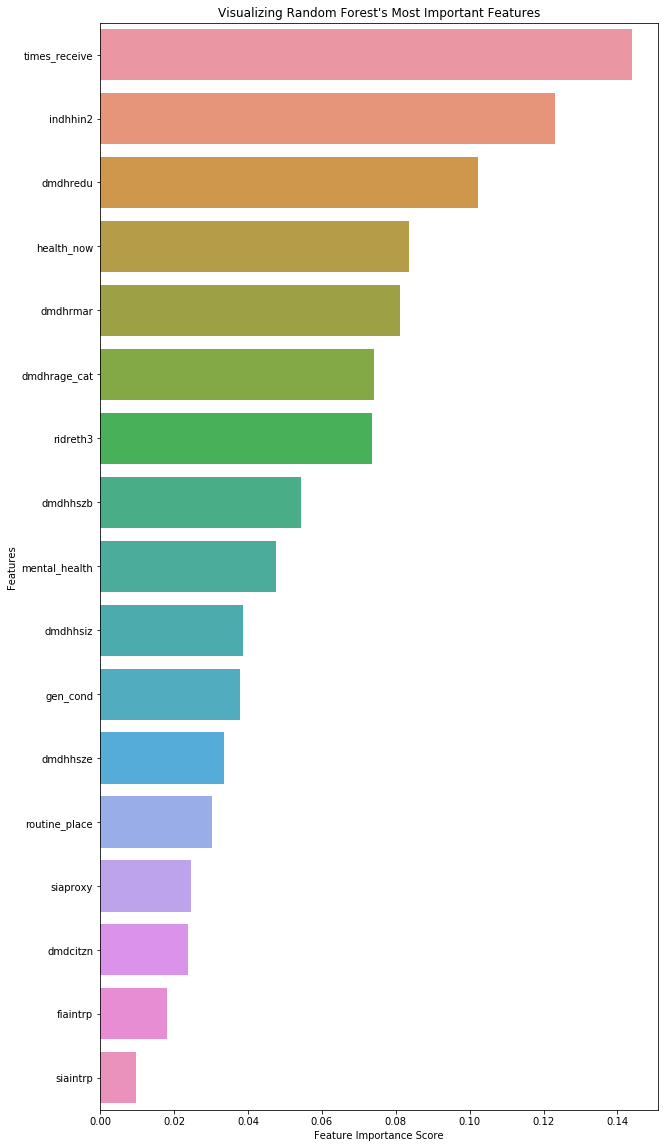

In [128]:
sns.barplot(x=rf_feat_imp, y=rf_feat_imp.index)   #plotting rf feature importance
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Random Forest's Most Important Features")
fig = plt.gcf()
fig.set_size_inches(10,20)
plt.show()

Yay! Now let's try to optimize a GBM.

In [129]:
gbm = GradientBoostingClassifier (n_estimators=200)   #first we'll just run a super simple gbm to see what happens
gbm_cv_scores = cross_val_score(gbm, X, y, cv=8)     

print('Accuracy scores for the 8 folds: ', gbm_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(gbm_cv_scores)))

Accuracy scores for the 8 folds:  [0.91646586 0.91325301 0.91237942 0.90916399 0.90909091 0.91230893
 0.91230893 0.91230893]
Mean cross validation score: 0.912


In [130]:
gbm.fit(X, y)
probs = gbm.predict_proba(X)[:, 1]

gbm_auc = roc_auc_score(y, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(gbm_auc))

Area under the ROC curve: 0.835


Well, initial impressions are that the GBM doesn't perform as well as the random forest, but of course, I haven't tried optimizing it at all yet.

In the interests of time, and because I'm slightly less familiar with gbm than with random forets, I'm going to use RandomSearch to come up with (hopefully) the best parameters.

In [131]:
empty_gbm = GradientBoostingClassifier()        #setting up gbm object to use in search

learning_rate = [.005, .007, .009, .010, .013, .015, .017, .020]
n_estimators = [200, 250, 300, 350, 400, 450, 500]
max_depth = [15, 16, 17, 18, 19, 20]                    #identifying params I'll use in randomized search
max_features = [None, 5, 6, 7, 8]
                                                      #and making them a dictionary
hyperparams = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

In [132]:
# Create randomized search 8-fold cross validation and 100 iterations 
random_gbm = RandomizedSearchCV(empty_gbm, hyperparams, n_iter=100, cv=8, verbose=0)

In [133]:
best_gbm = random_gbm.fit(X, y)     #fitting randomized search object
# # Viewing best hyperparameters
print('Best learning_rate:', best_gbm.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_gbm.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_gbm.best_estimator_.get_params()['max_depth'])
print('Best max_features:', best_gbm.best_estimator_.get_params()['max_features'])    

Best learning_rate: 0.005
Best n_estimators: 300
Best max_depth: 16
Best max_features: 5


In [139]:
#best params: lr: .005, n_estimators: 300, max_depth 16, max_features: 5
#let's put these best params in a regular old gbm model:
gbm_params = {'n_estimators': 300,
              'learning_rate': .005,
              'max_depth': 16,
              'max_features': 5
}

best_gbm = GradientBoostingClassifier(**gbm_params)
best_gbm_cv_scores = cross_val_score(best_gbm, X, y, cv=8)     

print('Accuracy scores for the 8 folds: ', best_gbm_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(best_gbm_cv_scores)))

Accuracy scores for the 8 folds:  [0.90281124 0.90200803 0.91157556 0.90192926 0.90265487 0.90587289
 0.90104586 0.90345937]
Mean cross validation score: 0.904


In [140]:
#now getting auc score:
best_gbm.fit(X, y)
probs = best_gbm.predict_proba(X)[:, 1]

best_gbm_auc = roc_auc_score(y, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(best_gbm_auc))

Area under the ROC curve: 0.994


So it does appear that the GBM (after going through the randomized search process) does slightly outperform the random forest. While the RF at its best had 90.2% accuracy and a 99.2% auc score, this GBM achieved 90.4% accuracy and a 99.4% auc score.

That's great. I'm going to use the GBM as my final model, since it does better than the other two models I've optimized on both accuracy and auc scores.

The next step is to run a feature importance analysis on this GBM. After that, I'll perform a statistical logistic regression to determine which features are statistically significant and also which are helping the model vs. hurting it (if any). This step will also tell us the odds of an overnight hospitalization outcome occurring, given a specified input. (More on this in a bit.)

In [142]:
#now running feature importance analysis on the gbm
gbm_model = best_gbm.fit(X, y)   #fitting the model
#getting feature importance (as series)
gbm_feat_imp = pd.Series(gbm_model.feature_importances_, index=X.columns.values).sort_values(ascending=False)   
gbm_feat_imp

times_receive    0.137547
indhhin2         0.121724
dmdhredu         0.102573
dmdhrmar         0.079646
health_now       0.078858
ridreth3         0.076545
dmdhrage_cat     0.075513
dmdhhszb         0.057392
mental_health    0.047581
dmdhhsiz         0.041094
gen_cond         0.035672
dmdhhsze         0.034009
routine_place    0.032240
dmdcitzn         0.025669
siaproxy         0.023428
fiaintrp         0.019683
siaintrp         0.010826
dtype: float64

It's a good sign that the percentages shown in this feature importance analysis fall in the same range as the feature importance of the RF model. For example, here the times_receive feature is at 13.8% importance, while in the RF model, it was at 14.4% importance, which is quite similar. This consistency is good, because it means it's likely neither of the models were done incorrectly. 

Now we'll plot the feature importance for the GBM.

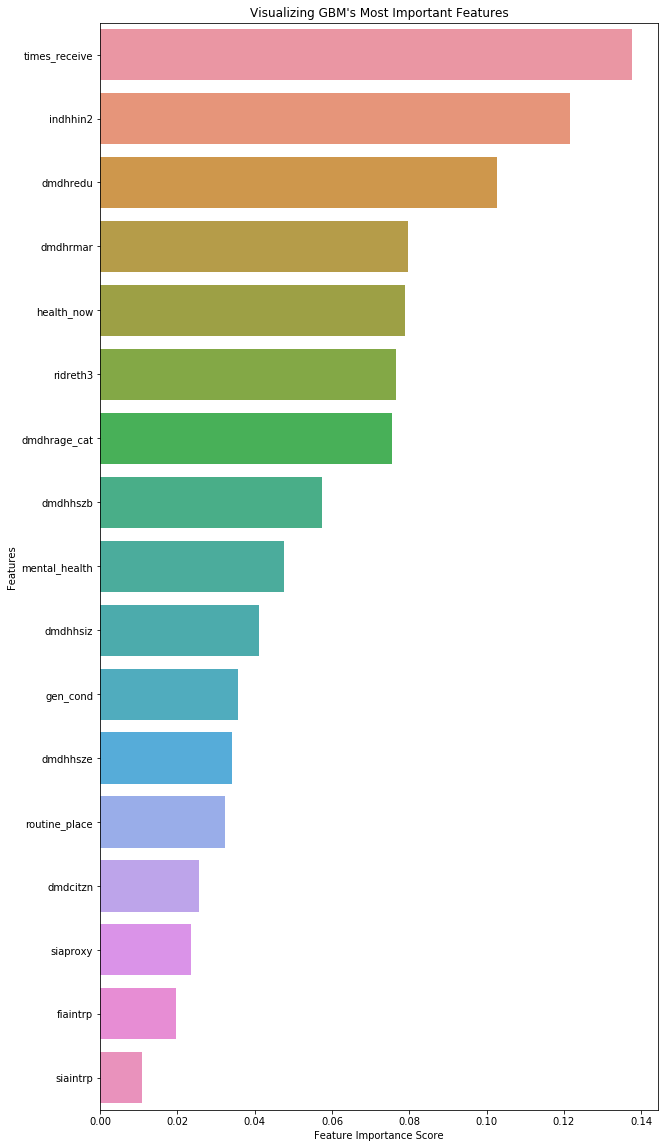

In [143]:
sns.barplot(x=gbm_feat_imp, y=gbm_feat_imp.index)     #plotting gbm feature importance
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing GBM's Most Important Features")
fig = plt.gcf()
fig.set_size_inches(10,20)
plt.show()

In [148]:
# statistical logistic regression for gbm
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now', 
      'ridreth3', 
      'dmdhrage_cat', 
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'gen_cond',
      'dmdhhsze'
      'routine_place',
      'dmdcitzn',
      'siaproxy',
      'fiaintrp',
      'siaintrp']])

gbm_lr = sm.Logit(endog, exog['const'])     #running it for the first time with just the constant for baseline

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.296096
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: ovrnight_hosp    AIC:              5894.3160
Date:               2020-03-18 13:20 BIC:              5901.5214
No. Observations:   9950             Log-Likelihood:   -2946.2  
Df Model:           0                LL-Null:          -2946.2  
Df Residuals:       9949             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const       2.3479     0.0355   66.0862   0.0000   2.2782   2.4175



/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


So this statistical logistic regression with just the constant tells us the constant (aka y-intercept) is 2.3479. Now we're ready to run it again, but this time with features.

In [156]:
#running it with all features of >= importance than dmdhhsze
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now', 
      'ridreth3', 
      'dmdhrage_cat', 
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'gen_cond',
      'dmdhhsze']])

#running it with all features of >= importance than dmdhhsze
gbm_lr = sm.Logit(endog, exog[['times_receive',
                              'indhhin2',
                              'dmdhredu',
                              'dmdhrmar',
                              'health_now',
                              'ridreth3',
                              'dmdhrage_cat',
                              'dmdhhszb',
                              'mental_health',
                              'dmdhhsiz',
                              'gen_cond',
                              'dmdhhsze']])     

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.302132
         Iterations 8
                               Results: Logit
Model:                   Logit                Pseudo R-squared:     -0.020   
Dependent Variable:      ovrnight_hosp        AIC:                  6034.4250
Date:                    2020-03-18 13:56     BIC:                  6113.6836
No. Observations:        9950                 Log-Likelihood:       -3006.2  
Df Model:                10                   LL-Null:              -2946.2  
Df Residuals:            9939                 LLR p-value:          1.0000   
Converged:               1.0000               Scale:                1.0000   
No. Iterations:          8.0000                                              
-----------------------------------------------------------------------------
               Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
------------------------------------------------------------------------

So, the first feature I see that is not statistically significant is ridreth3 (race/ethnicity), where p=1.0.
In my next stat lr, I'm going to remove this and see if it has a useful effect on the model overall.

In [157]:
#removing ridreth3 and seeing if it helps the model or not
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now',  
      'dmdhrage_cat', 
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'gen_cond',
      'dmdhhsze']])

#no ridreth3
gbm_lr = sm.Logit(endog, exog[['times_receive',
                              'indhhin2',
                              'dmdhredu',
                              'dmdhrmar',
                              'health_now',
                              'dmdhrage_cat',
                              'dmdhhszb',
                              'mental_health',
                              'dmdhhsiz',
                              'gen_cond',
                              'dmdhhsze']])     

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.302132
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.020   
Dependent Variable: ovrnight_hosp    AIC:              6034.4250
Date:               2020-03-18 14:32 BIC:              6113.6836
No. Observations:   9950             Log-Likelihood:   -3006.2  
Df Model:           10               LL-Null:          -2946.2  
Df Residuals:       9939             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
times_receive   -0.4336   0.0339 -12.7757 0.0000 -0.5002 -0.3671
indhhin2         0.3826   0.0308  12.4167 0.0000  0.3222  0.4430
dmdhredu     

Well, that was interesting. The AIC and BIC stayed exactly the same, but now dmdhrage_cat became statistically significant (p=0.0) whereas it wasn't before when ridreth3 was included (p was 1.0). Log-likelihood and LL-null also remained exactly the same.

So, for the time being, I'll just keep ridreth3 out. I can always put it back in if I need to.
Next, I'll see what happens when I remove gen_cond, which is also not statistically significant (p=.21).

In [158]:
#removing gen_cond while also keeping ridreth3 out
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now',  
      'dmdhrage_cat', 
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'dmdhhsze']])

#no gen_cond OR ridreth3
gbm_lr = sm.Logit(endog, exog[['times_receive',
                              'indhhin2',
                              'dmdhredu',
                              'dmdhrmar',
                              'health_now',
                              'dmdhrage_cat',
                              'dmdhhszb',
                              'mental_health',
                              'dmdhhsiz',
                              'dmdhhsze']])     

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.302212
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.021   
Dependent Variable: ovrnight_hosp    AIC:              6034.0147
Date:               2020-03-18 14:50 BIC:              6106.0680
No. Observations:   9950             Log-Likelihood:   -3007.0  
Df Model:           9                LL-Null:          -2946.2  
Df Residuals:       9940             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
times_receive   -0.4213   0.0325 -12.9626 0.0000 -0.4850 -0.3576
indhhin2         0.3828   0.0308  12.4339 0.0000  0.3225  0.4432
dmdhredu     

Hooray! This actually helped. AIC decreased a bit, and BIC decreased more substantially. Log-likelihood also decreased by 1, and LL-Null stayed the same.

Additionally, now all the features involved are statistically significant.

I think, since the removal of ridreth3 and gen_cond affected the overall model positively, I will keep it this way.

In [159]:
smallerX = X[['times_receive', 
              'indhhin2', 
              'dmdhredu', 
              'dmdhrmar', 
              'health_now', 
              'dmdhrage_cat', 
              'dmdhhszb',
              'mental_health',
              'dmdhhsiz',
              'dmdhhsze']]

In [160]:
params = {'n_estimators': 300,
              'learning_rate': .005,
              'max_depth': 16,
              'max_features': 5
}

best_gbm2 = GradientBoostingClassifier(**params)
best_gbm2_cv_scores = cross_val_score(best_gbm2, smallerX, y, cv=8)     

print('Accuracy scores for the 8 folds: ', best_gbm2_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(best_gbm2_cv_scores)))

Accuracy scores for the 8 folds:  [0.89558233 0.89638554 0.89630225 0.90594855 0.89782784 0.90104586
 0.88978278 0.89863234]
Mean cross validation score: 0.898


In [161]:
#now getting auc score:
best_gbm2.fit(smallerX, y)
probs = best_gbm2.predict_proba(smallerX)[:, 1]

best_gbm2_auc = roc_auc_score(y, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(best_gbm2_auc))

Area under the ROC curve: 0.983


Okay, so both score went down a little bit, but we can feel better about the model's accuracy anyway, because the less important features have been removed, so this model only relied on features that were significant and ultimately lowered the AIC & BIC.

Next I'm going to go through this process again, but removing the dmdhrage_cat variable first instead of ridreth3, and seeing where that takes us, and if we can ultimately come up with a better model using this route.

In [162]:
#running it with all features except dmdhrage_cat
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now', 
      'ridreth3',  
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'gen_cond',
      'dmdhhsze']])

#no dmdhrage_cat
gbm_lr = sm.Logit(endog, exog[['times_receive',
                              'indhhin2',
                              'dmdhredu',
                              'dmdhrmar',
                              'health_now',
                              'ridreth3',
                              'dmdhhszb',
                              'mental_health',
                              'dmdhhsiz',
                              'gen_cond',
                              'dmdhhsze']])     

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.302132
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.020   
Dependent Variable: ovrnight_hosp    AIC:              6034.4250
Date:               2020-03-19 10:10 BIC:              6113.6836
No. Observations:   9950             Log-Likelihood:   -3006.2  
Df Model:           10               LL-Null:          -2946.2  
Df Residuals:       9939             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
times_receive   -0.4336   0.0339 -12.7757 0.0000 -0.5002 -0.3671
indhhin2         0.3826   0.0308  12.4167 0.0000  0.3222  0.4430
dmdhredu     

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [163]:
#running without dmdhrage_cat OR gen_cond
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now', 
      'ridreth3',  
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'dmdhhsze']])

#no dmdhrage_cat OR gen_cond
gbm_lr = sm.Logit(endog, exog[['times_receive',
                              'indhhin2',
                              'dmdhredu',
                              'dmdhrmar',
                              'health_now',
                              'ridreth3',
                              'dmdhhszb',
                              'mental_health',
                              'dmdhhsiz',
                              'dmdhhsze']])     

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.302212
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.021   
Dependent Variable: ovrnight_hosp    AIC:              6034.0147
Date:               2020-03-19 10:20 BIC:              6106.0680
No. Observations:   9950             Log-Likelihood:   -3007.0  
Df Model:           9                LL-Null:          -2946.2  
Df Residuals:       9940             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
times_receive   -0.4213   0.0325 -12.9626 0.0000 -0.4850 -0.3576
indhhin2         0.3828   0.0308  12.4339 0.0000  0.3225  0.4432
dmdhredu     

Well, okay removing dmdhrage_cat instead of ridreth3 had exactly the same effect as removing only ridreth3. Then, removing both dmdhrage_cat & gen_cond had exactly the same effect as removing ridreth3 and gen_cond together.

I don't anticipate this version having a different auc and accuracy score from the first version, but I'll run those again anyway, to be thorough.

In [164]:
smallerX = X[['times_receive', 
              'indhhin2', 
              'dmdhredu', 
              'dmdhrmar', 
              'health_now', 
              'ridreth3', 
              'dmdhhszb',
              'mental_health',
              'dmdhhsiz',
              'dmdhhsze']]

In [165]:
params = {'n_estimators': 300,
              'learning_rate': .005,
              'max_depth': 16,
              'max_features': 5
}

best_gbm3 = GradientBoostingClassifier(**params)
best_gbm3_cv_scores = cross_val_score(best_gbm3, smallerX, y, cv=8)     

print('Accuracy scores for the 8 folds: ', best_gbm3_cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(best_gbm3_cv_scores)))

Accuracy scores for the 8 folds:  [0.89558233 0.89638554 0.89790997 0.90594855 0.89863234 0.90024135
 0.88897828 0.89863234]
Mean cross validation score: 0.898


In [166]:
#now getting auc score:
best_gbm3.fit(smallerX, y)
probs = best_gbm3.predict_proba(smallerX)[:, 1]

best_gbm3_auc = roc_auc_score(y, probs)    #getting auc score
print('Area under the ROC curve: {:.3f}'.format(best_gbm3_auc))

Area under the ROC curve: 0.983


Yeah, these scores are exactly the same as the previous ones. I'll just stick with the first version then, where we removed ridreth3 and gen_cond. I'll print it out directly below so we can see it again and use those variables.

In [167]:
#removing gen_cond while also keeping ridreth3 out
endog = y
exog = sm.add_constant(X.loc[:,[
      'indhhin2', 
      'times_receive', 
      'dmdhredu', 
      'dmdhrmar', 
      'health_now',  
      'dmdhrage_cat', 
      'dmdhhszb',
      'mental_health',
      'dmdhhsiz',
      'dmdhhsze']])

#no gen_cond OR ridreth3
gbm_lr = sm.Logit(endog, exog[['times_receive',
                              'indhhin2',
                              'dmdhredu',
                              'dmdhrmar',
                              'health_now',
                              'dmdhrage_cat',
                              'dmdhhszb',
                              'mental_health',
                              'dmdhhsiz',
                              'dmdhhsze']])     

gbm_lr_result = gbm_lr.fit()
print(gbm_lr_result.summary2())

Optimization terminated successfully.
         Current function value: 0.302212
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.021   
Dependent Variable: ovrnight_hosp    AIC:              6034.0147
Date:               2020-03-19 11:00 BIC:              6106.0680
No. Observations:   9950             Log-Likelihood:   -3007.0  
Df Model:           9                LL-Null:          -2946.2  
Df Residuals:       9940             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
times_receive   -0.4213   0.0325 -12.9626 0.0000 -0.4850 -0.3576
indhhin2         0.3828   0.0308  12.4339 0.0000  0.3225  0.4432
dmdhredu     

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Moving on, I'm going to turn this statistical logistic regression into an odds ratio so we can actually have a sense of what real business cases would look like and explain the relationships between the variables and target.

In [168]:
model_odds = pd.DataFrame(np.exp(gbm_lr_result.params), columns=['Odds Ratios'])
model_odds['p-value']= gbm_lr_result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(gbm_lr_result.conf_int())
model_odds

,Odds Ratios,p-value,2.5%,97.5%
times_receive,0.656219,1.994516e-38,0.615724,0.699377
indhhin2,1.466440,1.711446e-35,1.380562,1.557660
dmdhredu,1.731756,1.102417e-27,1.568988,1.911410
dmdhrmar,1.423385,8.716256e-14,1.297283,1.561745
health_now,0.999054,5.817047e-06,0.998645,0.999463
dmdhrage_cat,1.231734,2.161316e-21,1.179875,1.285871
dmdhhszb,2.921723,2.788695e-53,2.548261,3.349918
mental_health,1.001036,5.739916e-11,1.000726,1.001346
dmdhhsiz,1.282248,1.007077e-02,1.061054,1.549552
dmdhhsze,1.783341,2.828171e-15,1.544864,2.058631


Great! So now I'm going to interpret the odds ratios for all of these variables, for ease of understanding:

times_receive: for each fewer time participants received healthcare during the year, they are 35% less likely to not be hospitalized.